# Repeater spectral analysis

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import pylab as pl
import numpy as np
import rtpipe, sdmpy
import rtlib_cython as rtlib
from astropy import coordinates
from scipy.optimize import curve_fit

2016-12-16 18:02:18,372 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)



In [3]:
# SNR from realfast using telcal gain solutions
snrdet = {'57623': 35.2, '57633_scan7': 119.3, '57633_scan13': 16.3, '57638': 9.9, '57643': 69.9,
         '57645': 11.1, '57646': 16.0, '57648': 17.6, '57649': 25.2} 

# flux scale from Bryan
calstring = """2.0520    2.89698    0.00279
2.1800    *******    *******
2.3080    *******    *******
2.4360    3.53585    0.00377
2.5640    3.69554    0.00376
2.6920    3.85507    0.00423
2.8200    4.00438    0.00486
2.9480    4.11069    0.00562
3.0520    4.20375    0.00631
3.1800    4.29385    0.00662
3.3080    4.36557    0.00715
3.4360    4.43684    0.00786
3.5640    4.46937    0.00850
3.6920    4.52488    0.00860
3.8200    4.53571    0.00969
3.9480    4.54625    0.00859""" 
# parse flux scale
freq = []
flux = []
eflux = []
for line in calstring.split('\n'): 
    if '*' not in line:
        result = line.split()
        freq.append(float(result[0]))
        flux.append(float(result[1]))
        eflux.append(float(result[2]))
calfreq = np.array(freq)
calflux = np.array(flux)
print(calfreq, calflux)

[ 2.052  2.436  2.564  2.692  2.82   2.948  3.052  3.18   3.308  3.436
  3.564  3.692  3.82   3.948] [ 2.89698  3.53585  3.69554  3.85507  4.00438  4.11069  4.20375  4.29385
  4.36557  4.43684  4.46937  4.52488  4.53571  4.54625]


## Functions to read and analyze data

In [4]:
def getscannum(sdmfile):
    sdm = rtpipe.parsesdm.getsdm(sdmfile)
    for scan in sdm.scans():
        try:
            print('Scan {0} binary data file: {1}'.format(scan.idx, scan.bdf.fname))
            bdfscan = int(scan.idx)
        except IOError:
            pass
    return bdfscan

def read_cut(sdmfile, scan, segment, dm=558., dt=1, gainfile=None, **kwargs):
    if not gainfile:
        gainfile = '.'.join(sdmfile.split('.')[:-1] + ['GN'])

    st = rtpipe.RT.set_pipeline(sdmfile, scan, dmarr=[dm], dtarr=[dt], flaglist=[('badap', 3., 0.2)], 
                                uvoversample=1.5, gainfile=gainfile, flagantsol=True, 
                                timesub='mean', logfile=False, savecands=False,
                                savenoise=False, **kwargs)
        
    data = rtpipe.RT.pipeline_reproduce(st, candloc=[segment,0,0,0,0], product='data')
    u, v, w = rtpipe.parsesdm.get_uvw_segment(st, segment)

    return st, data, u, v, w

def imloc(st, data, u, v, w, integ, verbose=0, weight='uniform'):
    if weight == 'uniform':
        weightarr = np.ones_like(data)
    elif weight == 'uvdist':
        uvd = np.sqrt(u**2+v**2)
        weightarr = np.ones_like(data)
        for bl in range(st['nbl']):
            weightarr[:,bl] *= uvd[bl]/uvd.max()

    im = rtpipe.RT.sample_image(st, data*weightarr, u, v, w, i=integ)
    l,m = rtpipe.RT.calc_lm(st, im)
    ra_center, dec_center = st['radec']
    ra, dec = rtpipe.reproduce.source_location(ra_center, dec_center, l, m)
    ras = ra.split()
    decs = dec.split()
    loc = coordinates.SkyCoord('{0}h{1}m{2}s'.format(ras[0], ras[1], ras[2]),
                               '{0}d{1}m{2}s'.format(decs[0], decs[1], decs[2]), frame='icrs')

    if verbose:
        print('Peak location:')
        print(l, m)
        print(loc.ra.hms, loc.dec.dms)
    return im, loc

def correctdata(st, data, u, v, w, corr='ph,dm', lm = (-3.85e-04,5.45e-04)):
    data2 = data.copy()
    
    if 'ph' in corr:
        l1, m1 = lm
        rtlib.phaseshift_threaded(data2, st, l1, m1, u, v)

    if 'dm' in corr:
        rtlib.dedisperse_par(data2, st['freq'], st['inttime'], st['dmarr'][0], [0, st['nbl']])
    
    return data2

# get array2 for bin in array near value
def find_nearest(array, array2, value):
    idx = (np.abs(array-value)).argmin()
    return array2[idx]

def getscale(st):
    # get flux scaling at nearest frequency
    scale = []
    for i in range(len(st['freq'])):
        freq = st['freq'][i]
        scale.append(find_nearest(calfreq, calflux, freq))
#         print(i, st['freq'][i], scale)
    scale = np.array(scale, dtype='complex64')[None,None,:,None]
    return scale

def correct_all(st, data, u, v, w):
    scale = getscale(st)
    dataph = correctdata(st, data*scale, u, v, w, corr='ph')
    dataphdm = correctdata(st, dataph, u, v, w, corr='dm')
    return dataphdm

def correct_and_plot(st, data, u, v, w, integ):
    scale = getscale(st)
    dataph = correctdata(st, data*scale, u, v, w, corr='ph')
    dataphdm = correctdata(st, dataph, u, v, w, corr='dm')

    fig = pl.figure(figsize=(15,8))
    ax = fig.add_subplot(131)
    sgram = dataphdm[integ-10:integ+10].mean(axis=3).mean(axis=1).real.transpose()
    pl.imshow(sgram, interpolation='nearest', origin='lower', cmap='viridis')
    pl.xlabel('Integration')
    pl.ylabel('Channel')
    ax = fig.add_subplot(132)
    spectra = dataphdm[integ-10:integ+10].mean(axis=2).mean(axis=1).real
    pl.plot(spectra[:,0], 'c.', label='RR')
    pl.plot(spectra[:,1], 'm.', label='LL')
    pl.legend()
    pl.xlabel('Integration')
    pl.ylabel('Amplitude')
    ax = fig.add_subplot(133)
    datadm = correctdata(st, data*scale, u, v, w, corr='dm')
    im, loc = imloc(st, datadm, u, v, w, integ, verbose=1)
    pl.imshow(im.transpose(), interpolation='nearest', cmap='viridis', aspect='equal')
    print('Image SNR {0}'.format(im.max()/im.std()))
    pl.xlabel('RA offset (pix)', fontsize=20)
    pl.ylabel('Dec offset (pix)', fontsize=20)
    xt = pl.setp(ax.get_xticklabels(), fontsize=14)
    yt = pl.setp(ax.get_yticklabels(), fontsize=14)
    ax.xaxis.set_tick_params(width=3, color='w')
    ax.yaxis.set_tick_params(width=3, color='w')

    fig = pl.figure(figsize=(3,6))
    ax = fig.add_subplot(111)
    sgram = dataph[integ-10:integ+50].mean(axis=3).mean(axis=1).real.transpose()
    extent = (0, 60*st['inttime'], st['freq'][0], st['freq'][-1])
    pl.imshow(sgram, interpolation='nearest', origin='lower', cmap='viridis',
              vmax=sgram.max()*0.8, extent=extent)
    pl.xlabel('Time (s, relative)', fontsize=14)
    pl.ylabel('Frequency (GHz)', fontsize=14)
    xt = pl.setp(ax.get_xticklabels(), fontsize=14)
    yt = pl.setp(ax.get_yticklabels(), fontsize=14)
    ax.xaxis.set_tick_params(width=2, color='k')
    ax.yaxis.set_tick_params(width=2, color='k')
    pl.xticks(np.linspace(0, 60*st['inttime'], 4))
    pl.colorbar()

    fig = pl.figure(figsize=(6,3))
    ax = fig.add_subplot(111)
    spectra = dataphdm[integ].mean(axis=0).real
    print('(RR-LL)/(RR+LL): {0}'.format(np.mean((spectra[:,0]-spectra[:,1])).real/np.mean((spectra[:,0]+spectra[:,1])).real))
    print('(RR+LL): {0}'.format(np.mean((spectra[:,0]+spectra[:,1])).real))
    nint, nbl, nch, npol = data.shape
    pl.scatter(range(0, nch), spectra[:,0], marker='.', c='c', label='RR', edgecolors='none')
    pl.scatter(range(0, nch), spectra[:,1], marker='.', c='m', label='LL', edgecolors='none')
    resamp = 16
    minch = 0
    if nch < 256:
        minch = resamp - (256-nch)
    print(minch, nch, resamp, spectra[minch:,0].shape)
    pl.scatter(range(minch, nch, resamp), spectra[minch:,0].reshape((256-minch)/resamp, resamp).mean(axis=1), 
               marker='_', c='c', s=500, edgecolors='c')
    pl.scatter(range(minch, nch, resamp), spectra[minch:,1].reshape((256-minch)/resamp, resamp).mean(axis=1), 
               marker='_', c='m', s=500, edgecolors='m')

    off = np.ma.masked_equal(dataphdm.mean(axis=1).real[range(0,integ-2)+range(integ+3,len(dataphdm))], 0)
    noise = off.std(axis=0)
    noiseRR = np.median(noise[:,0])
    noiseLL = np.median(noise[:,1])
    pl.errorbar(230, spectra.max(), yerr=noiseRR, fmt='c.', ecolor='c')
    pl.text(230, spectra.max(), s='RR', verticalalignment='center', horizontalalignment='left')
    pl.errorbar(240, spectra.max(), yerr=noiseLL, fmt='m.', ecolor='m')
    pl.text(240, spectra.max(), s='LL', verticalalignment='center', horizontalalignment='left')
#    pl.errorbar(range(nch), spectra[:,0], yerr=noise[:,0], fmt='c.', ecolor='c')
#    pl.errorbar(range(nch), spectra[:,1], yerr=noise[:,1], fmt='m.', ecolor='m')
#    pl.legend()
    pl.xlabel('Frequency (GHz)', fontsize=14)
    pl.ylabel('Flux density (Jy)', fontsize=14)
    pl.xlim(-5, nch+5)
    pl.xticks(range(0, nch+1, 32), [str(np.round(2.489+ch*0.004096, 2)) for ch in range(0, nch+1, 32)])
    xt = pl.setp(ax.get_xticklabels(), fontsize=14)
    yt = pl.setp(ax.get_yticklabels(), fontsize=14)
    ax.xaxis.set_tick_params(width=2, color='k')
    ax.yaxis.set_tick_params(width=2, color='k')
    return spectra

def find_dm(st, data, u, v, w):
    scale = getscale(st)

    dmorig = st['dmarr']
    snrs = []
    for dm in range(530, 600, 2):
        st['dmarr'] = [dm]
        datadm = correctdata(st, data*scale, u, v, w, corr='dm')
        datadmph = correctdata(st, datadm, u, v, w, corr='ph')
        lc = datadmph.mean(axis=3).mean(axis=2).mean(axis=1).real
        integ = np.where(lc.max() == lc)[0][0]
        im, loc = imloc(st, datadm, u, v, w, integ)
        imc = im.transpose()[-1000:, 1000:]
        mad = np.median(np.abs(imc - np.median(imc)))
        std = mad/0.67
        snr = im.max()/std
        snrs.append((dm, integ, snr))
    st['dmarr'] = dmorig

    snrs = np.array(snrs)
    snrmax_ind = np.where(snrs[:,2] == snrs[:,2].max())[0][0]
    print('SNR vs DM: {0}'.format(snrs))
    print('Max SNR of {0} at DM={1}'.format(snrs[snrmax_ind, 2], snrs[snrmax_ind, 0]))
    return snrs[snrmax_ind]

In [5]:
read = {}
spectrum = {}

In [6]:
cd ~/16A-459/fastimaging/

/lustre/aoc/projects/16A-459/fastimaging


In [7]:
sdmfile = '16A-459_TEST_1hr.57623.72670021991.cut'
key = '57623'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 2, npix_max=4096)

2016-12-16 18:02:25,006 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-16 18:02:25,007 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-16 18:02:25,008 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-459_TEST_1hr.57623.72670021991.GN
2016-12-16 18:02:25,009 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-16 18:02:25,010 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-16 18:02:25,011 - rtpipe.parsesdm - INFO - Setting (standard) key npix_max to 4096
2016-12-16 18:02:25,012 - rtpipe.parsesdm - INFO - Setting (standard) key savecands to False
2016-12-16 18:02:25,012 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to [('badap', 3.0, 0.2)]
2016-12-16 18:02:25,013 - rtpipe.parsesdm - INFO - Setting (standard) key savenoise to False
2016-12-16 18:02:25,014 - rtpipe.parsesdm - INFO - Setting (standard) key flagantsol to True
2016-12-16 18:02:25,015 - rtpipe.parses

Scan 6 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-459_TEST_1hr.57623.72670021991.cut/ASDMBinary/uid____evla_bdf_1471974264507


2016-12-16 18:02:25,312 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14]
2016-12-16 18:02:25,387 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 6 of source FRB121102-off
2016-12-16 18:02:25,556 - rtpipe.parsesdm - INFO - 

2016-12-16 18:02:25,556 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-16 18:02:25,557 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-459_TEST_1hr.57623.72670021991.cut
2016-12-16 18:02:25,559 - rtpipe.parsesdm - INFO - 	 Using scan 6, source FRB121102-off
2016-12-16 18:02:25,559 - rtpipe.parsesdm - INFO - 	 nants, nbl: 27, 351
2016-12-16 18:02:25,560 - rtpipe.parsesdm - INFO - 	 Freq range (2.489 -- 3.509). 8 spw with 256 chans.
2016-12-16 18:02:25,561 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-16 18:02:25,562 - rtpipe.parsesdm - INFO - 	 2 polarizations: ['RR', 'LL']
2016-12-16 18:02:25,56

In [8]:
key = '57623'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)

Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.

Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Peak location:
-0.000382092830009 0.000539752492877
hms_tuple(h=5.0, m=31.0, s=58.726811858099168) dms_tuple(d=33.0, m=8.0, s=52.331952522986285)
Image SNR 35.9967782898
(RR-LL)/(RR+LL): -0.0121865458786
(RR+LL): 0.255277872086
0 256 16 (256,)
Image SNR (orig): 35.2


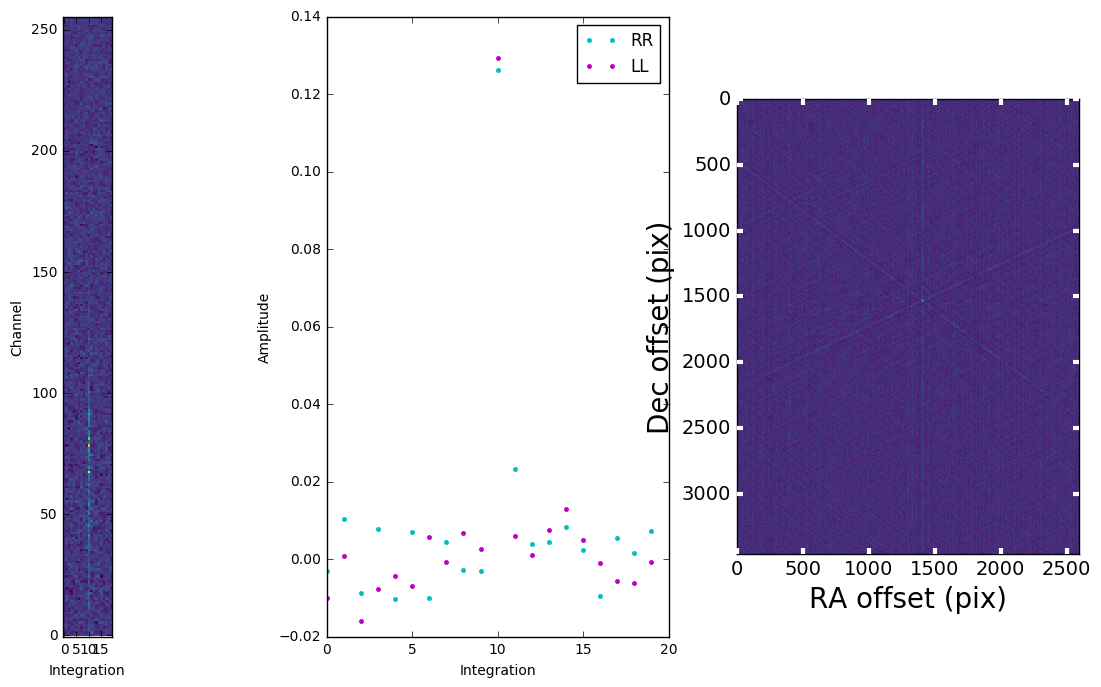

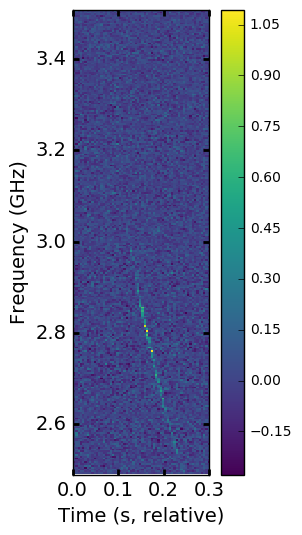

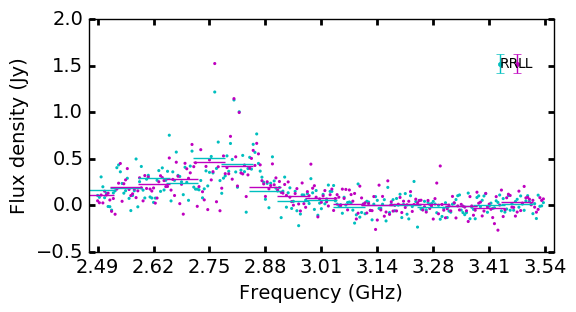

In [9]:
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [10]:
sdmfile = '16A-459_TEST_1hr_000.57633.66130137732.scan7.cut'
key = '57633_scan7'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 2, gainfile='16A-459_TEST_1hr_000.57633.66130137732.GN',
                               npix_max=4096)

2016-12-16 18:04:13,141 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-16 18:04:13,142 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-16 18:04:13,143 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-459_TEST_1hr_000.57633.66130137732.GN
2016-12-16 18:04:13,143 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-16 18:04:13,144 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-16 18:04:13,145 - rtpipe.parsesdm - INFO - Setting (standard) key npix_max to 4096
2016-12-16 18:04:13,145 - rtpipe.parsesdm - INFO - Setting (standard) key savecands to False
2016-12-16 18:04:13,146 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to [('badap', 3.0, 0.2)]
2016-12-16 18:04:13,147 - rtpipe.parsesdm - INFO - Setting (standard) key savenoise to False
2016-12-16 18:04:13,148 - rtpipe.parsesdm - INFO - Setting (standard) key flagantsol to True
2016-12-16 18:04:13,148 - rtpipe.pa

Scan 7 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-459_TEST_1hr_000.57633.66130137732.scan7.cut/ASDMBinary/uid____evla_bdf_1472832853393


2016-12-16 18:04:13,446 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14]
2016-12-16 18:04:13,521 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 7 of source FRB121102-off
2016-12-16 18:04:13,621 - rtpipe.parsesdm - INFO - 

2016-12-16 18:04:13,622 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-16 18:04:13,623 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-459_TEST_1hr_000.57633.66130137732.scan7.cut
2016-12-16 18:04:13,624 - rtpipe.parsesdm - INFO - 	 Using scan 7, source FRB121102-off
2016-12-16 18:04:13,624 - rtpipe.parsesdm - INFO - 	 nants, nbl: 27, 351
2016-12-16 18:04:13,625 - rtpipe.parsesdm - INFO - 	 Freq range (2.489 -- 3.509). 8 spw with 256 chans.
2016-12-16 18:04:13,626 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-16 18:04:13,626 - rtpipe.parsesdm - INFO - 	 2 polarizations: ['RR', 'LL']
2016-12-16 1

Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.

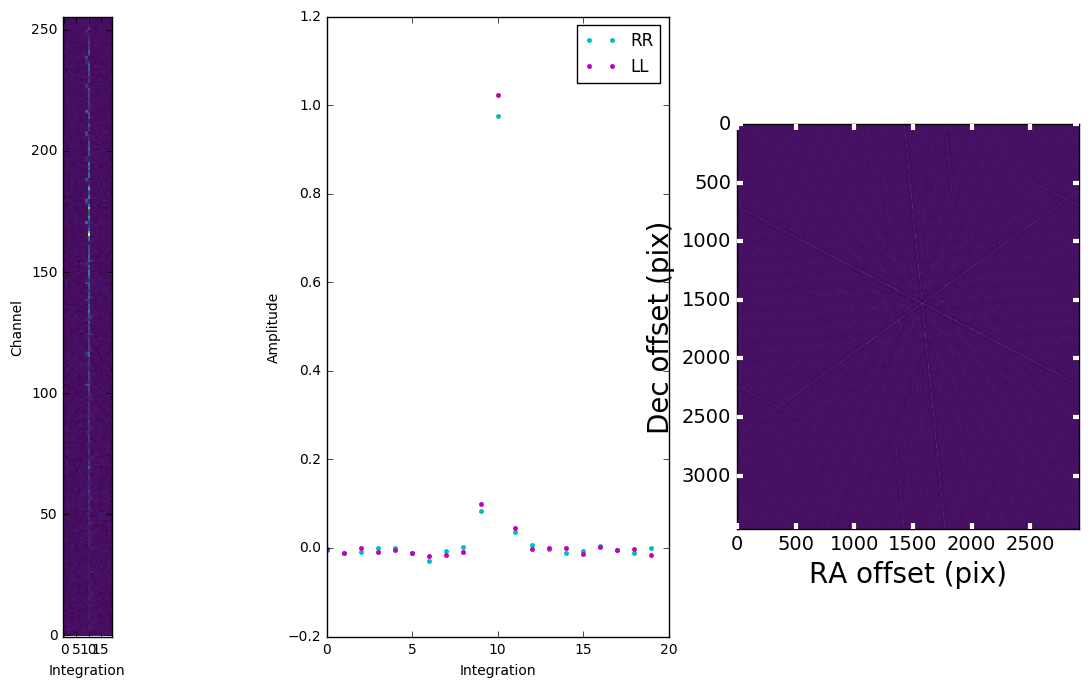

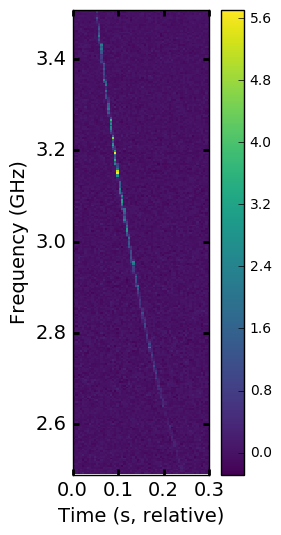

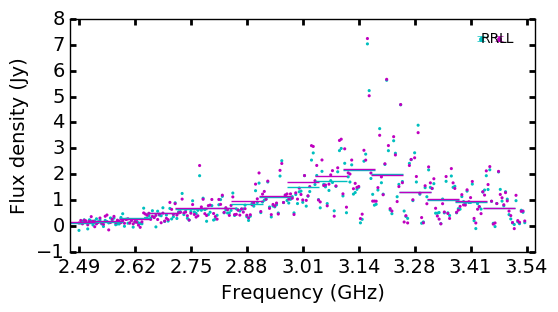

In [11]:
key = '57633_scan7'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [12]:
sdmfile = '16A-459_TEST_1hr_000.57633.66130137732.scan13.cut'
key = '57633_scan13'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 2, gainfile='16A-459_TEST_1hr_000.57633.66130137732.GN', npix_max=4096)

2016-12-16 18:06:08,351 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-16 18:06:08,351 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-16 18:06:08,352 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-459_TEST_1hr_000.57633.66130137732.GN
2016-12-16 18:06:08,353 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-16 18:06:08,354 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-16 18:06:08,354 - rtpipe.parsesdm - INFO - Setting (standard) key npix_max to 4096
2016-12-16 18:06:08,355 - rtpipe.parsesdm - INFO - Setting (standard) key savecands to False
2016-12-16 18:06:08,356 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to [('badap', 3.0, 0.2)]
2016-12-16 18:06:08,357 - rtpipe.parsesdm - INFO - Setting (standard) key savenoise to False
2016-12-16 18:06:08,357 - rtpipe.parsesdm - INFO - Setting (standard) key flagantsol to True
2016-12-16 18:06:08,358 - rtpipe.pa

Scan 13 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-459_TEST_1hr_000.57633.66130137732.scan13.cut/ASDMBinary/uid____evla_bdf_1472834169774


2016-12-16 18:06:08,657 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14]
2016-12-16 18:06:08,732 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 13 of source FRB121102-off
2016-12-16 18:06:08,833 - rtpipe.parsesdm - INFO - 

2016-12-16 18:06:08,833 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-16 18:06:08,834 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-459_TEST_1hr_000.57633.66130137732.scan13.cut
2016-12-16 18:06:08,835 - rtpipe.parsesdm - INFO - 	 Using scan 13, source FRB121102-off
2016-12-16 18:06:08,836 - rtpipe.parsesdm - INFO - 	 nants, nbl: 27, 351
2016-12-16 18:06:08,836 - rtpipe.parsesdm - INFO - 	 Freq range (2.489 -- 3.509). 8 spw with 256 chans.
2016-12-16 18:06:08,837 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-16 18:06:08,838 - rtpipe.parsesdm - INFO - 	 2 polarizations: ['RR', 'LL']
2016-12-16

Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.

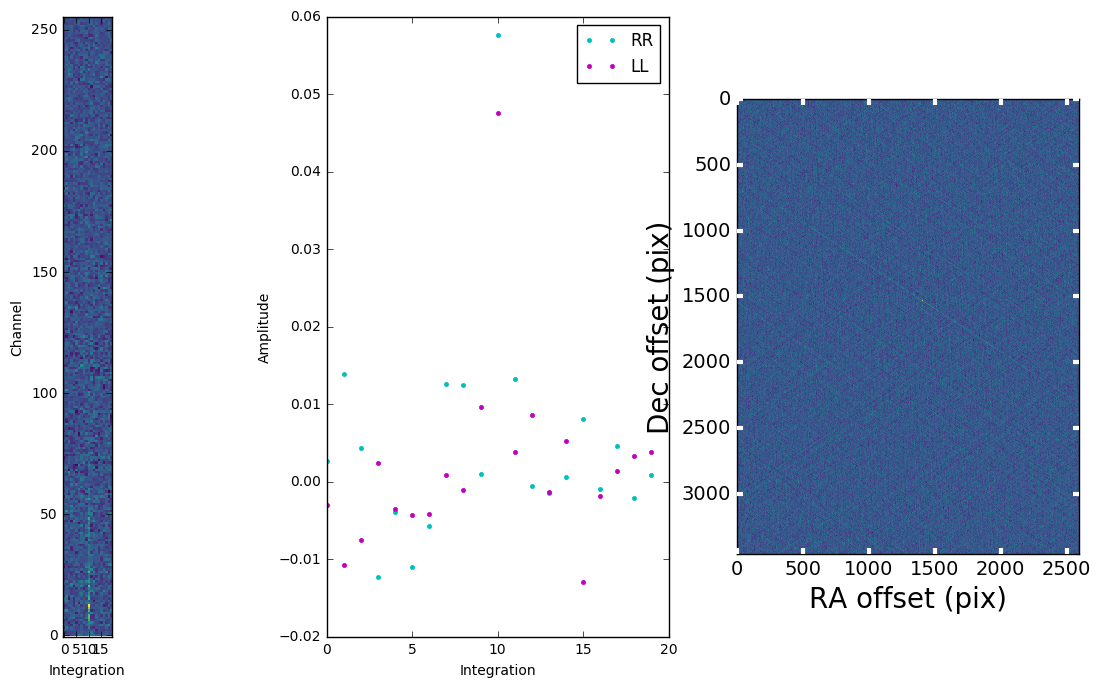

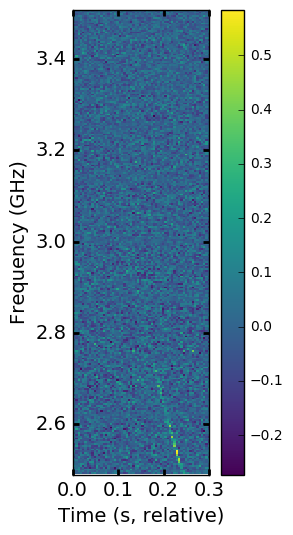

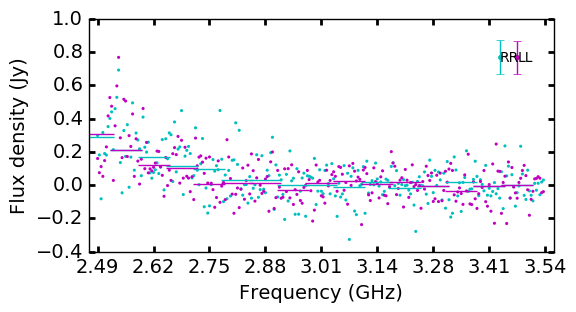

In [13]:
key = '57633_scan13'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [14]:
sdmfile = '16A-496_sb32698778_1_02h00m.57638.42695471065.cut'
key = '57638'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 4, npix_max=5500, chans=range(2,256))

2016-12-16 18:07:55,829 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-16 18:07:55,830 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-16 18:07:55,831 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m.57638.42695471065.GN
2016-12-16 18:07:55,832 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-16 18:07:55,832 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-16 18:07:55,833 - rtpipe.parsesdm - INFO - Setting (standard) key chans to [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107

Scan 29 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-496_sb32698778_1_02h00m.57638.42695471065.cut/ASDMBinary/uid____evla_bdf_1473249228150


2016-12-16 18:07:56,360 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33]
2016-12-16 18:07:56,487 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 29 of source FRB121102-off
2016-12-16 18:07:56,635 - rtpipe.parsesdm - INFO - 

2016-12-16 18:07:56,636 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-16 18:07:56,637 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-496_sb32698778_1_02h00m.57638.42695471065.cut
2016-12-16 18:07:56,638 - rtpipe.parsesdm - INFO - 	 Using scan 29, source FRB121102-off
2016-12-16 18:07:56,638 - rtpipe.parsesdm - INFO - 	 nants, nbl: 26, 325
2016-12-16 18:07:56,639 - rtpipe.parsesdm - INFO - 	 Freq range (2.497 -- 3.509). 8 spw with 254 chans.
2016-12-16 18:07:56,640 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-16 18:07:

Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"

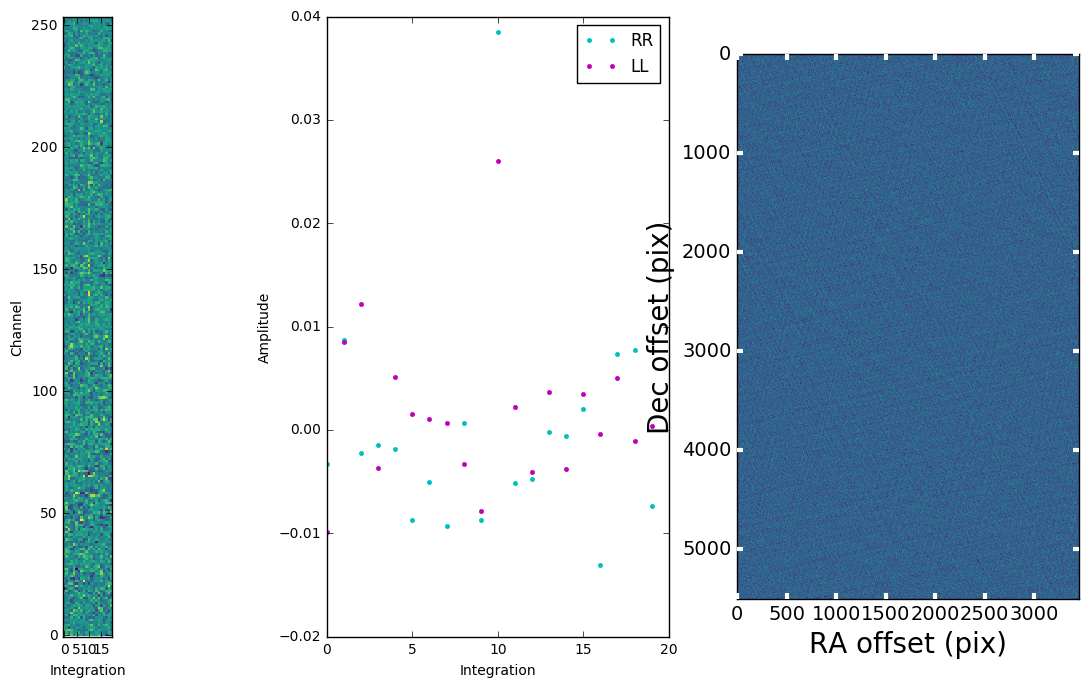

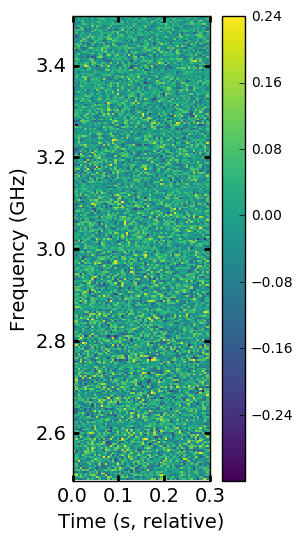

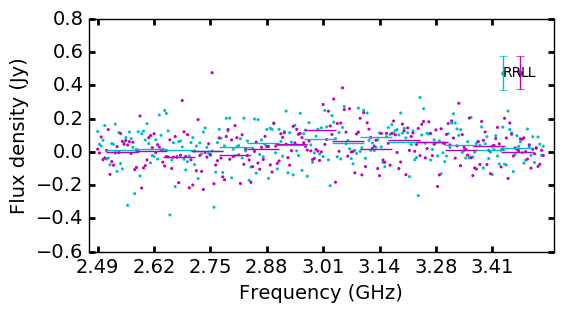

In [15]:
key = '57638'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [16]:
sdmfile = '16A-496_sb32698778_1_02h00m_001.57643.38562630787.cut/'
key = '57643'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 4, npix_max=5500)

2016-12-16 18:10:00,421 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-16 18:10:00,422 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-16 18:10:00,423 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m_001.57643.38562630787.GN
2016-12-16 18:10:00,423 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-16 18:10:00,424 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-16 18:10:00,425 - rtpipe.parsesdm - INFO - Setting (standard) key npix_max to 5500
2016-12-16 18:10:00,425 - rtpipe.parsesdm - INFO - Setting (standard) key savecands to False
2016-12-16 18:10:00,426 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to [('badap', 3.0, 0.2)]
2016-12-16 18:10:00,427 - rtpipe.parsesdm - INFO - Setting (standard) key savenoise to False
2016-12-16 18:10:00,427 - rtpipe.parsesdm - INFO - Setting (standard) key flagantsol to True
2016-12-16 18:10:00,428 

Scan 29 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-496_sb32698778_1_02h00m_001.57643.38562630787.cut/ASDMBinary/uid____evla_bdf_1473677657337


2016-12-16 18:10:00,907 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33]
2016-12-16 18:10:01,030 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 29 of source FRB121102-off
2016-12-16 18:10:01,176 - rtpipe.parsesdm - INFO - 

2016-12-16 18:10:01,177 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-16 18:10:01,178 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-496_sb32698778_1_02h00m_001.57643.38562630787.cut
2016-12-16 18:10:01,179 - rtpipe.parsesdm - INFO - 	 Using scan 29, source FRB121102-off
2016-12-16 18:10:01,180 - rtpipe.parsesdm - INFO - 	 nants, nbl: 26, 325
2016-12-16 18:10:01,180 - rtpipe.parsesdm - INFO - 	 Freq range (2.489 -- 3.509). 8 spw with 256 chans.
2016-12-16 18:10:01,181 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-16 18

Gridded 1.000 of data. Scaling fft by = 180.2
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 179.9
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 180.0
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 179.6
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 180.1
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 180.0
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 179.8
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 180.0
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 179.8
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 179.0
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 178.9
Pixel sizes (0.9", 0.7"), Field size 1983.3"

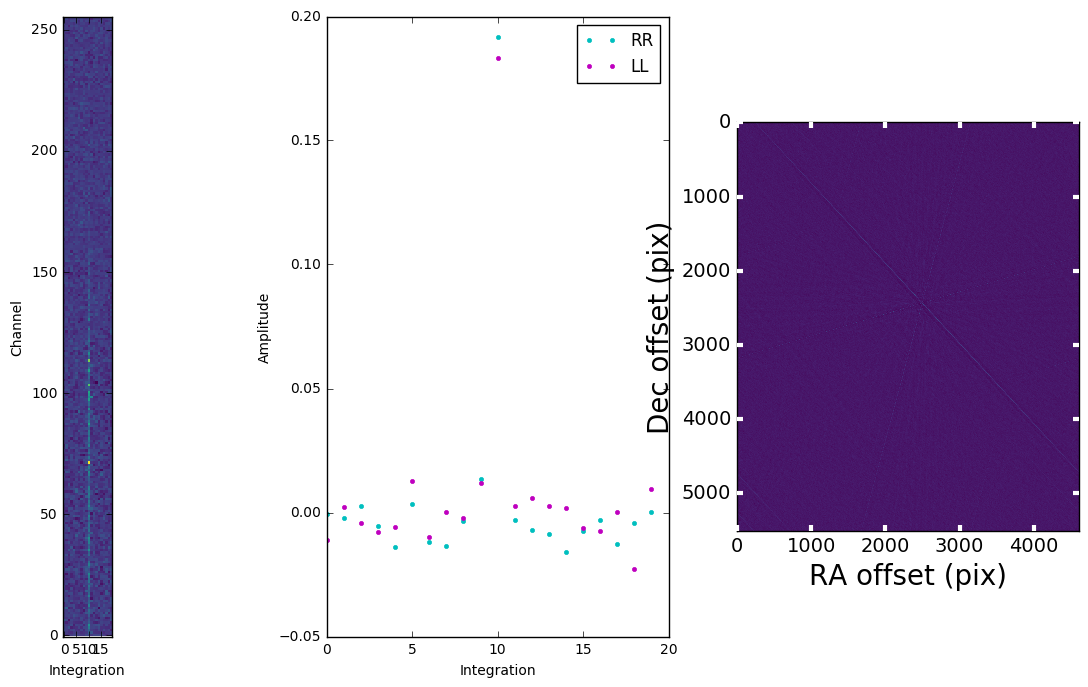

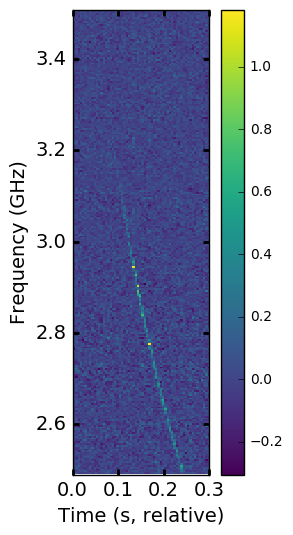

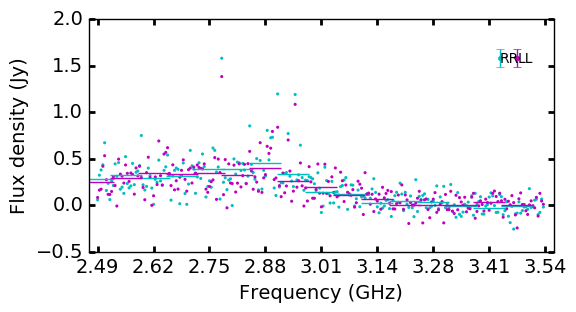

In [17]:
key = '57643'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [18]:
sdmfile = '16A-496_sb32698778_1_02h00m.57645.38915079861.cut'
key = '57645'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 6, npix_max=6500, chans=range(4,256))

2016-12-16 18:12:18,528 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-16 18:12:18,529 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-16 18:12:18,530 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m.57645.38915079861.GN
2016-12-16 18:12:18,530 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-16 18:12:18,531 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-16 18:12:18,532 - rtpipe.parsesdm - INFO - Setting (standard) key chans to [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108,

Scan 16 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-496_sb32698778_1_02h00m.57645.38915079861.cut/ASDMBinary/uid____evla_bdf_1473848163356


2016-12-16 18:12:19,056 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
2016-12-16 18:12:19,195 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 16 of source FRB121102-off
2016-12-16 18:12:19,356 - rtpipe.parsesdm - INFO - 

2016-12-16 18:12:19,357 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-16 18:12:19,358 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-496_sb32698778_1_02h00m.57645.38915079861.cut
2016-12-16 18:12:19,359 - rtpipe.parsesdm - INFO - 	 Using scan 16, source FRB121102-off
2016-12-16 18:12:19,359 - rtpipe.parsesdm - INFO - 	 nants, nbl: 27, 351
2016-12-16 18:12:19,360 - rtpipe.parsesdm - INFO - 	 Freq range (2.505 -- 3.509). 8 spw with 252 chans.
2016-12-16 18:12:19,361 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-16 18:12:

Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"

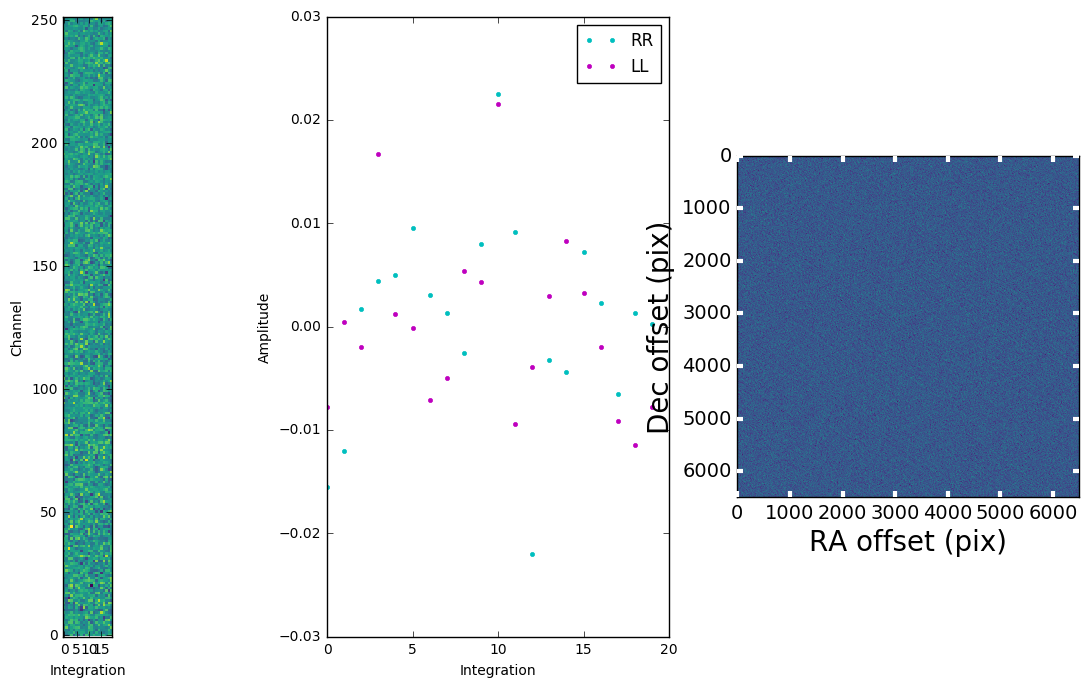

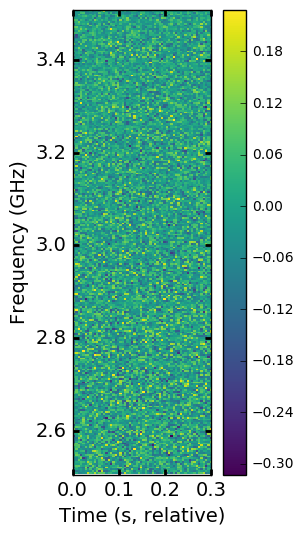

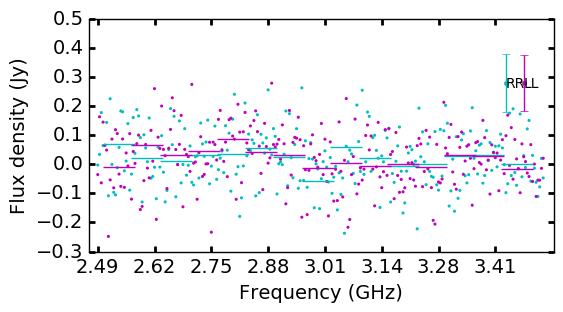

In [19]:
key = '57645'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [20]:
sdmfile = '16A-496_sb32698778_1_02h00m_000.57646.38643644676.cut'
key = '57646'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 6, npix_max=7000, chans=range(3,256))

2016-12-16 18:15:43,301 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-16 18:15:43,302 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-16 18:15:43,302 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m_000.57646.38643644676.GN
2016-12-16 18:15:43,304 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-16 18:15:43,305 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-16 18:15:43,306 - rtpipe.parsesdm - INFO - Setting (standard) key chans to [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 10

Scan 32 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-496_sb32698778_1_02h00m_000.57646.38643644676.cut/ASDMBinary/uid____evla_bdf_1473937600955


2016-12-16 18:15:43,887 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33]
2016-12-16 18:15:44,034 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 32 of source FRB121102-off
2016-12-16 18:15:44,205 - rtpipe.parsesdm - INFO - 

2016-12-16 18:15:44,206 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-16 18:15:44,207 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-496_sb32698778_1_02h00m_000.57646.38643644676.cut
2016-12-16 18:15:44,208 - rtpipe.parsesdm - INFO - 	 Using scan 32, source FRB121102-off
2016-12-16 18:15:44,208 - rtpipe.parsesdm - INFO - 	 nants, nbl: 27, 351
2016-12-16 18:15:44,209 - rtpipe.parsesdm - INFO - 	 Freq range (2.501 -- 3.509). 8 spw with 253 chans.
2016-12-16 18:15:44,210 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-16 18

Gridded 1.000 of data. Scaling fft by = 304.7
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 304.4
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 304.7
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 304.6
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 304.6
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 304.7
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 304.8
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 302.8
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 302.7
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 303.1
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 302.9
Pixel sizes (0.6", 0.6"), Field size 1983.3"

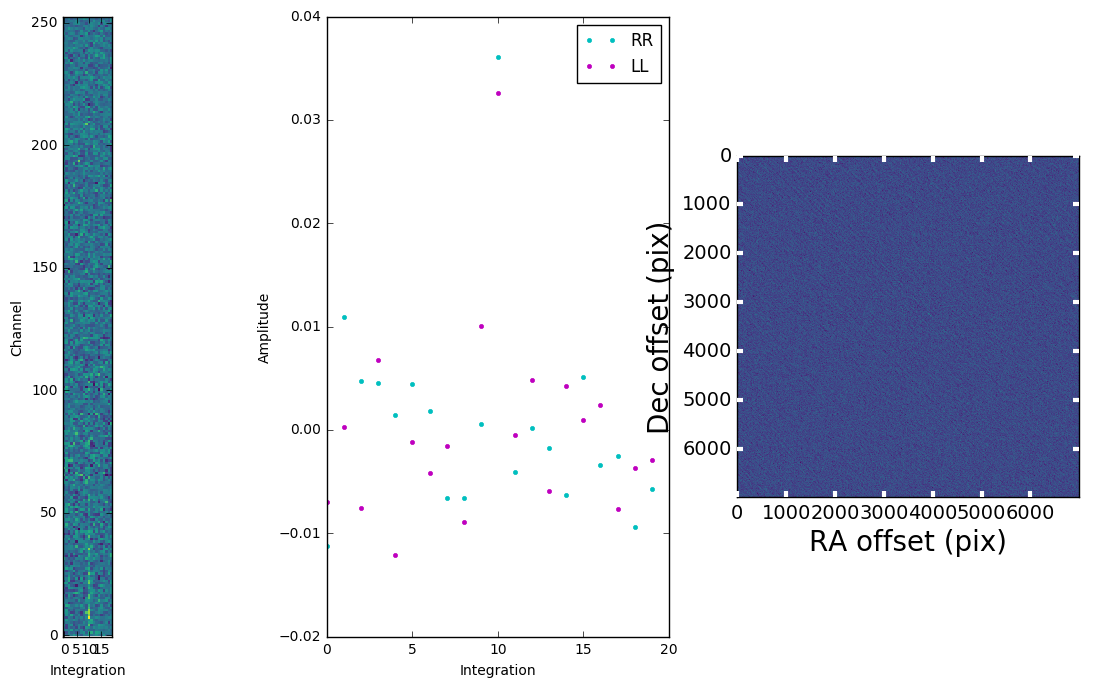

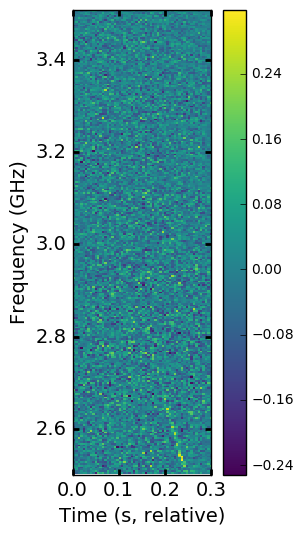

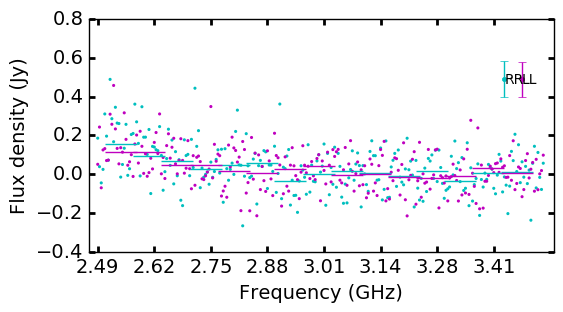

In [21]:
key = '57646'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [22]:
sdmfile = '16A-496_sb32698778_1_02h00m_000.57648.37452900463.cut/'
key = '57648'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 7, npix_max=7400, chans=range(2,256))

2016-12-16 18:18:53,914 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-16 18:18:53,915 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-16 18:18:53,916 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m_000.57648.37452900463.GN
2016-12-16 18:18:53,917 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-16 18:18:53,918 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-16 18:18:53,919 - rtpipe.parsesdm - INFO - Setting (standard) key chans to [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,

Scan 25 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-496_sb32698778_1_02h00m_000.57648.37452900463.cut/ASDMBinary/uid____evla_bdf_1474107905881


2016-12-16 18:18:54,477 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33]
2016-12-16 18:18:54,620 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 25 of source FRB121102-off
2016-12-16 18:18:54,796 - rtpipe.parsesdm - INFO - 

2016-12-16 18:18:54,797 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-16 18:18:54,797 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-496_sb32698778_1_02h00m_000.57648.37452900463.cut
2016-12-16 18:18:54,798 - rtpipe.parsesdm - INFO - 	 Using scan 25, source FRB121102-off
2016-12-16 18:18:54,799 - rtpipe.parsesdm - INFO - 	 nants, nbl: 27, 351
2016-12-16 18:18:54,800 - rtpipe.parsesdm - INFO - 	 Freq range (2.497 -- 3.509). 8 spw with 254 chans.
2016-12-16 18:18:54,800 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-16 18

Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"

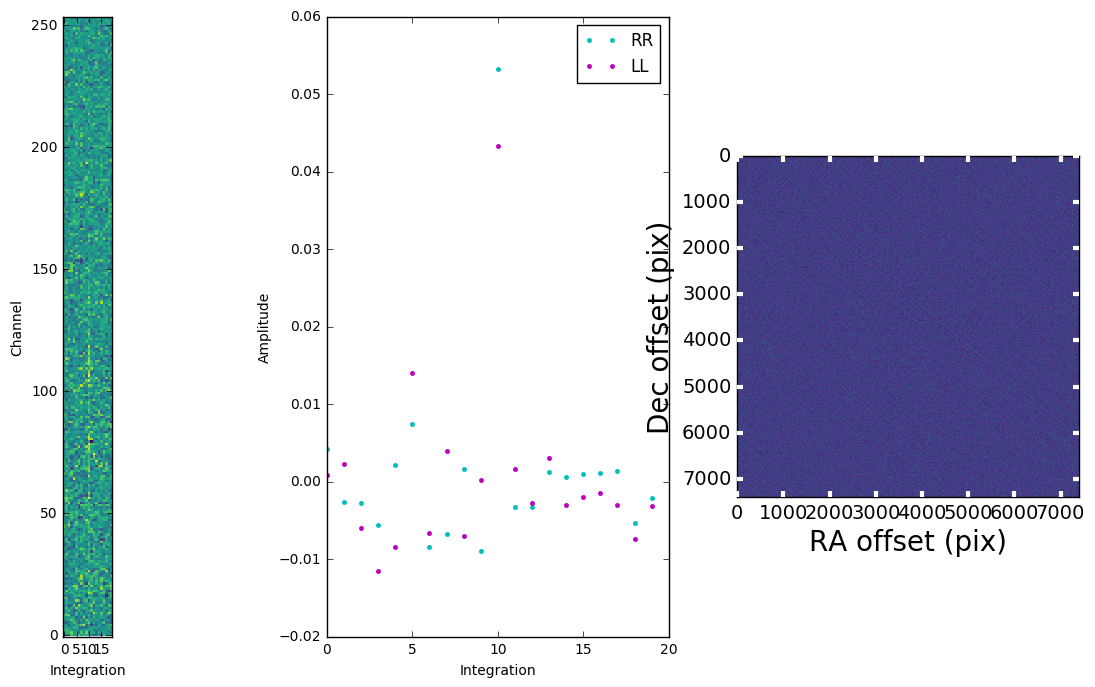

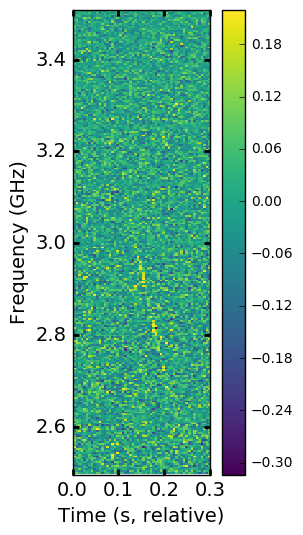

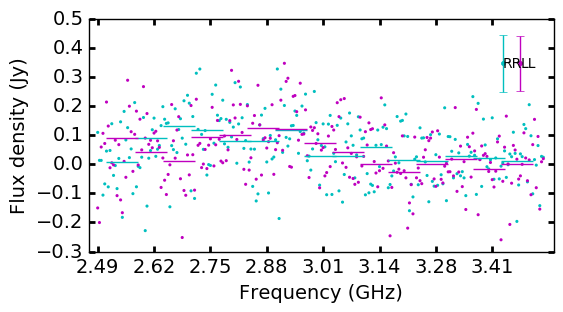

In [23]:
key = '57648'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [24]:
sdmfile = '16A-496_sb32698778_1_02h00m_001.57649.37461215278.cut/'
key = '57649'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 7, npix_max=7400)

2016-12-16 18:23:33,958 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-16 18:23:33,959 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-16 18:23:33,960 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m_001.57649.37461215278.GN
2016-12-16 18:23:33,961 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-16 18:23:33,962 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-16 18:23:33,963 - rtpipe.parsesdm - INFO - Setting (standard) key npix_max to 7400
2016-12-16 18:23:33,963 - rtpipe.parsesdm - INFO - Setting (standard) key savecands to False
2016-12-16 18:23:33,964 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to [('badap', 3.0, 0.2)]
2016-12-16 18:23:33,965 - rtpipe.parsesdm - INFO - Setting (standard) key savenoise to False
2016-12-16 18:23:33,966 - rtpipe.parsesdm - INFO - Setting (standard) key flagantsol to True
2016-12-16 18:23:33,967 

Scan 31 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-496_sb32698778_1_02h00m_001.57649.37461215278.cut/ASDMBinary/uid____evla_bdf_1474195554648


2016-12-16 18:23:34,531 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33]
2016-12-16 18:23:34,672 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 31 of source FRB121102-off
2016-12-16 18:23:34,836 - rtpipe.parsesdm - INFO - 

2016-12-16 18:23:34,837 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-16 18:23:34,838 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-496_sb32698778_1_02h00m_001.57649.37461215278.cut
2016-12-16 18:23:34,839 - rtpipe.parsesdm - INFO - 	 Using scan 31, source FRB121102-off
2016-12-16 18:23:34,839 - rtpipe.parsesdm - INFO - 	 nants, nbl: 26, 325
2016-12-16 18:23:34,840 - rtpipe.parsesdm - INFO - 	 Freq range (2.489 -- 3.509). 8 spw with 256 chans.
2016-12-16 18:23:34,841 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-16 18

Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"

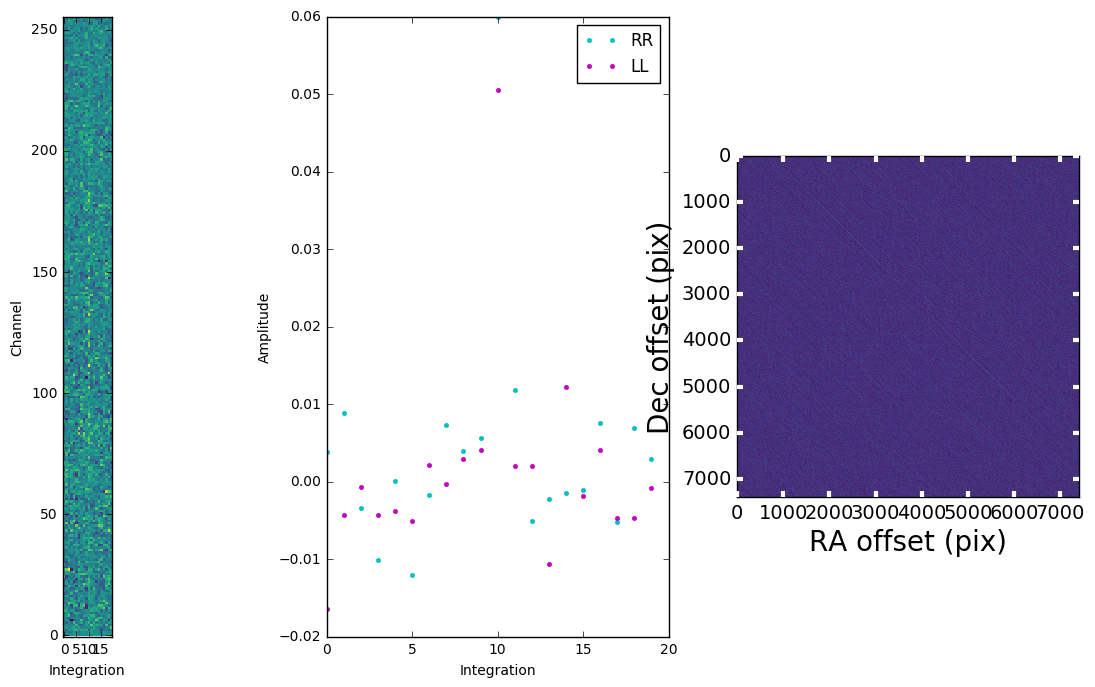

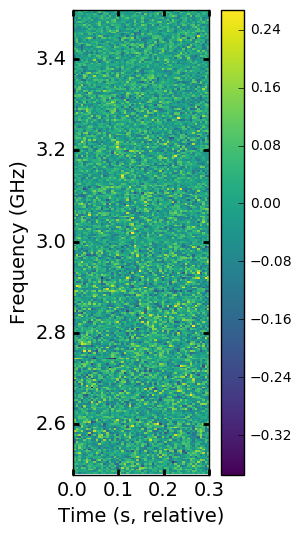

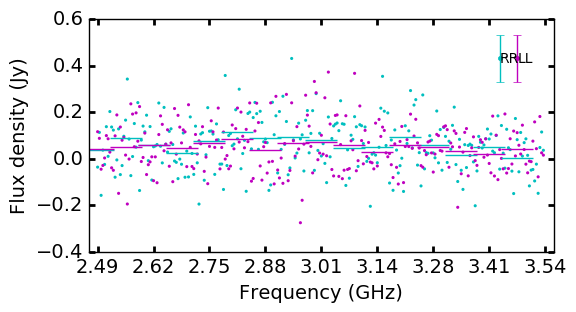

In [25]:
key = '57649'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
print('Image SNR (orig): {0}'.format(snrdet[key]))

## Spectral autocorrelation

In [26]:
def plot_acf(st, data, u, v, w, integ):
    pl.figure(figsize=(7,7))
    dataphdm = correct_all(st, data, u, v, w)
    spec = dataphdm[integ].mean(axis=2).mean(axis=0).real
    spec_off = dataphdm[integ+3].mean(axis=2).mean(axis=0).real
    ac = np.correlate(spec, spec, mode='same')
    ac_off = np.correlate(spec_off, spec_off, mode='same')
    pl.plot(ac, '.')
    pl.plot(ac_off, '.')

57633_scan7
57649
57638
57646
57633_scan13
57645
57648
57643
57623


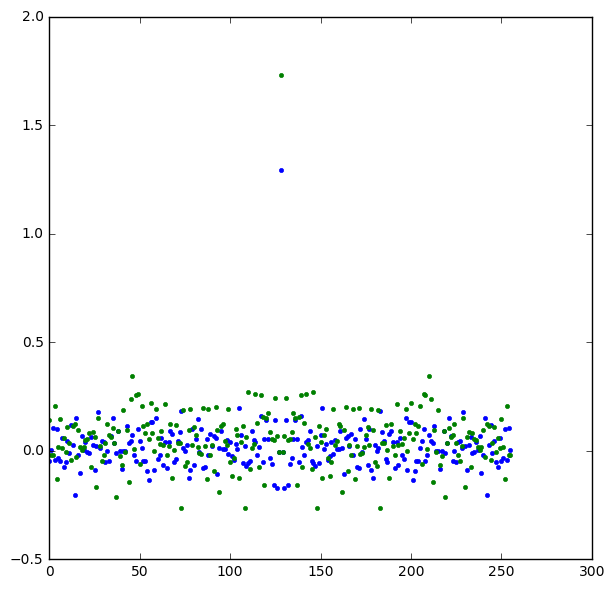

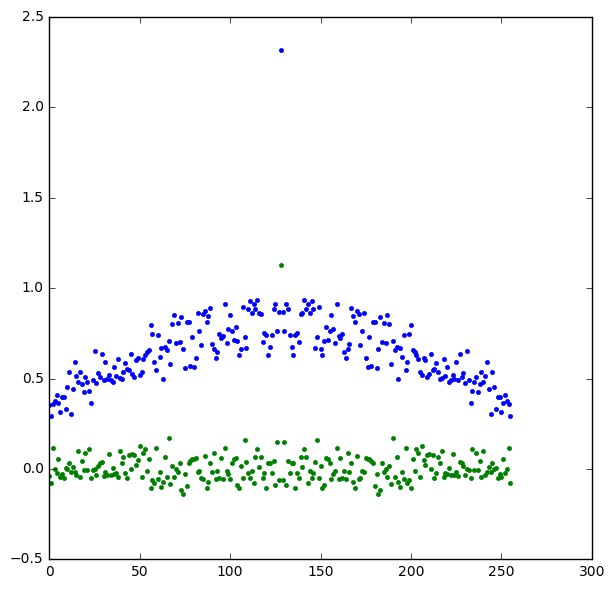

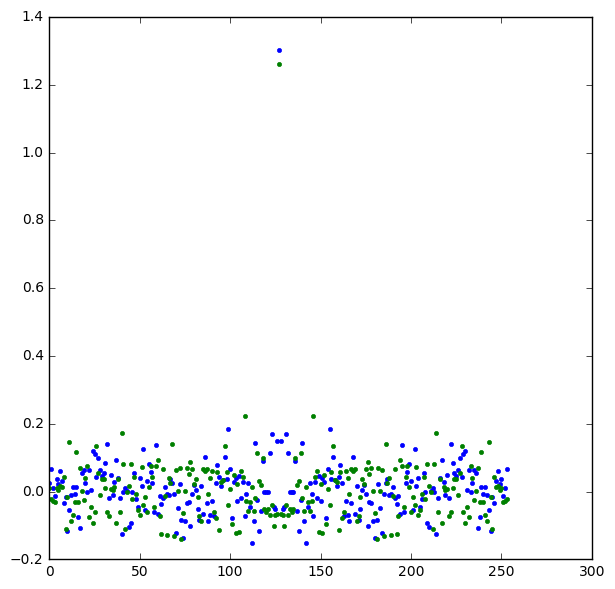

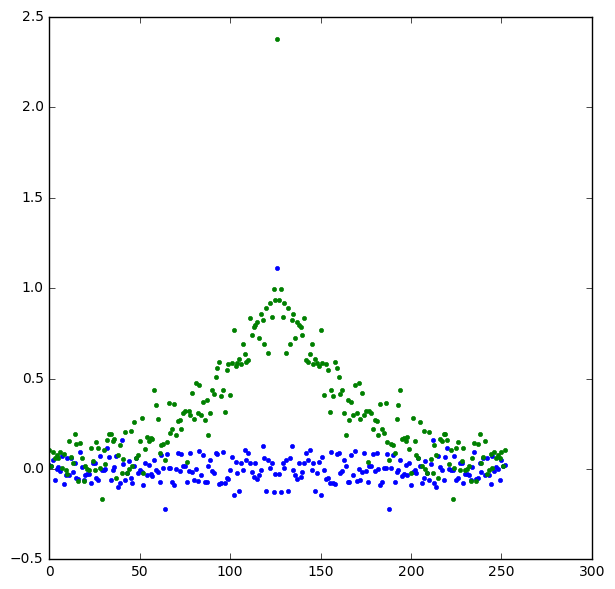

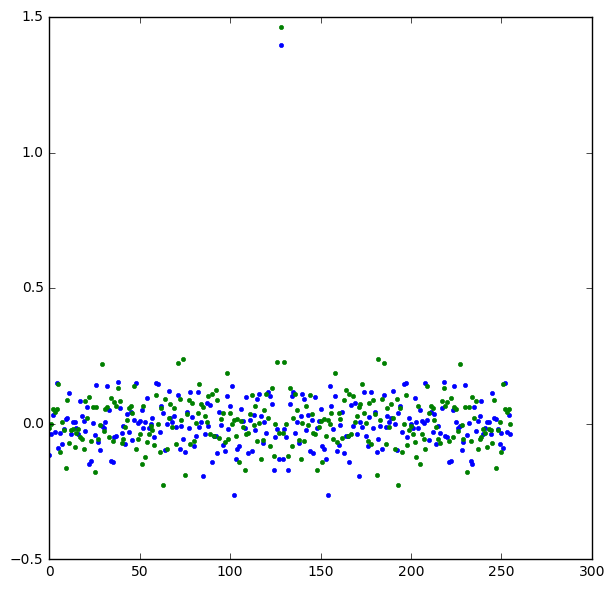

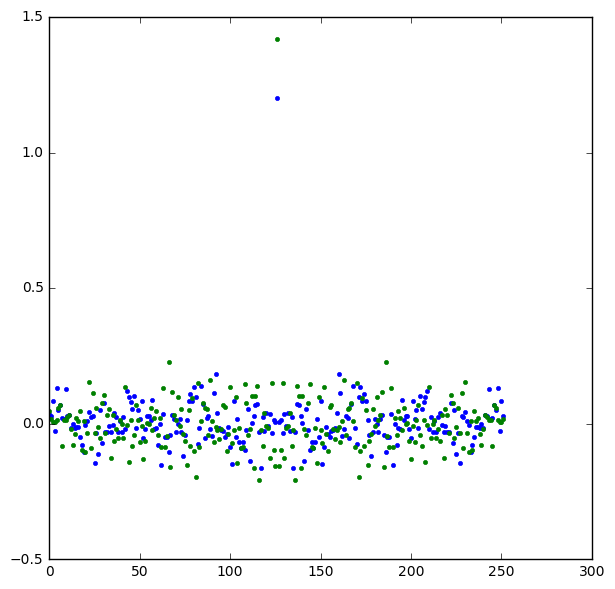

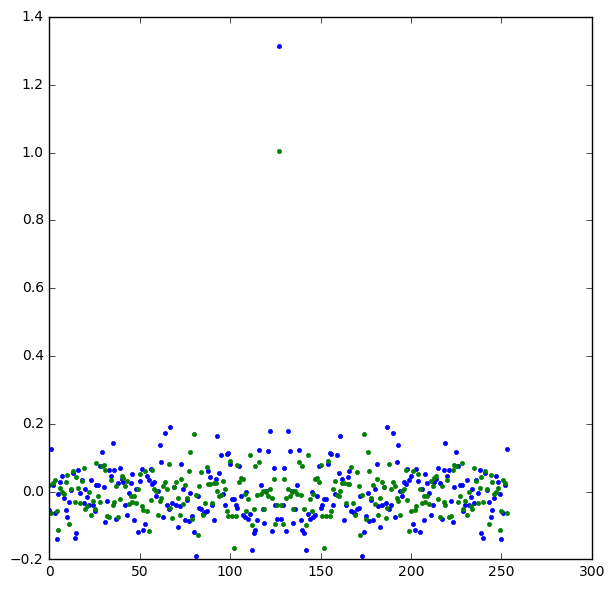

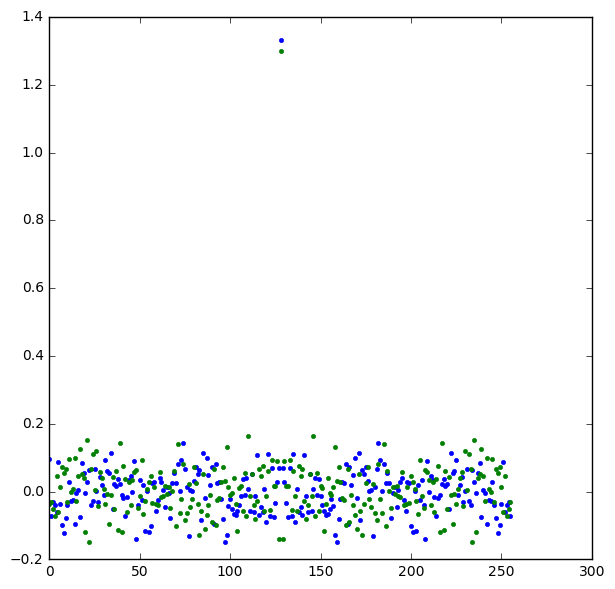

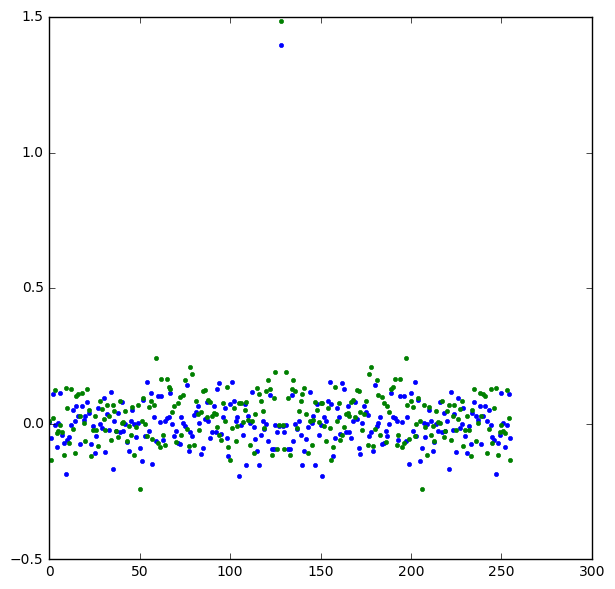

In [27]:
for key in snrdet.keys():
    print(key)
    st, data, u, v, w = read[key]
    plot_acf(st, data, u, v, w, integ)

## Spectral Modeling

In [28]:
import scipy.stats
from scipy.optimize import curve_fit

def norm(x, a, loc, scale):
    return a*scipy.stats.norm(loc, scale).pdf(x)

def fitandplot(spectrum, popt_fixed=None, axis=()):
    nch = len(spectrum)
    
    if not popt_fixed:
        bounds = ([1, 0, 10], [2000, 200, 150])
        popt, pcov = curve_fit(norm, np.arange(nch), spectrum, bounds=bounds)
    else:
        popt = popt_fixed

    print(popt)
        
    normsol = norm(np.arange(nch), *popt)

    pl.figure(figsize=(15,7))
    pl.errorbar(range(nch), spectrum, fmt='c.', ecolor='c')
    pl.plot(np.arange(nch), normsol, 'k')
    if len(axis):
        pl.axis(axis)
    pl.xlabel('Channel')
    pl.xlim(0, nch)
    pl.ylabel('Flux and model')
    return popt

sc = lambda sig: np.sqrt(2*sig**2*np.pi)

In [29]:
popt = {'57623': [ 33.18660225 , 68.6786758  , 31.97989185],
        '57633_scan7': [ 261.01468348,  163.37613653 ,  54.94315806],
        '57633_scan13': [ 25.91234327 ,  0. , 36.83456147],
        '57643': [ 54.70339027 , 68.70560927,  55.53711055],
        '57649': [17.31563655, 104.88902813 ,  93.62882441],
        '57638': [8.03104856,  159.12796452,   43.9087101 ],
        '57646': [1.67436907e+01, 0.,  4.26219468e+01],
        '57645': [3.63342113,  85.9990355,   22.58927418],
        '57648': [ 12.25215549,  87.65698285,  44.20621731]}

[261.01468348, 163.37613653, 54.94315806]
Fit 57633_scan7 (peak, center, fwhm): 1895.23 & 3.2 & 518
[17.31563655, 104.88902813, 93.62882441]
Fit 57649 (peak, center, fwhm): 73.78 & 2.9 & 882
[8.03104856, 159.12796452, 43.9087101]
Fit 57638 (peak, center, fwhm): 72.97 & 3.1 & 414
[16.7436907, 0.0, 42.6219468]
Fit 57646 (peak, center, fwhm): 156.72 & 2.5 & 401
[25.91234327, 0.0, 36.83456147]
Fit 57633_scan13 (peak, center, fwhm): 280.65 & 2.5 & 347
[3.63342113, 85.9990355, 22.58927418]
Fit 57645 (peak, center, fwhm): 64.17 & 2.8 & 213
[12.25215549, 87.65698285, 44.20621731]
Fit 57648 (peak, center, fwhm): 110.57 & 2.9 & 416
[54.70339027, 68.70560927, 55.53711055]
Fit 57643 (peak, center, fwhm): 392.95 & 2.8 & 523
[33.18660225, 68.6786758, 31.97989185]
Fit 57623 (peak, center, fwhm): 414.00 & 2.8 & 301


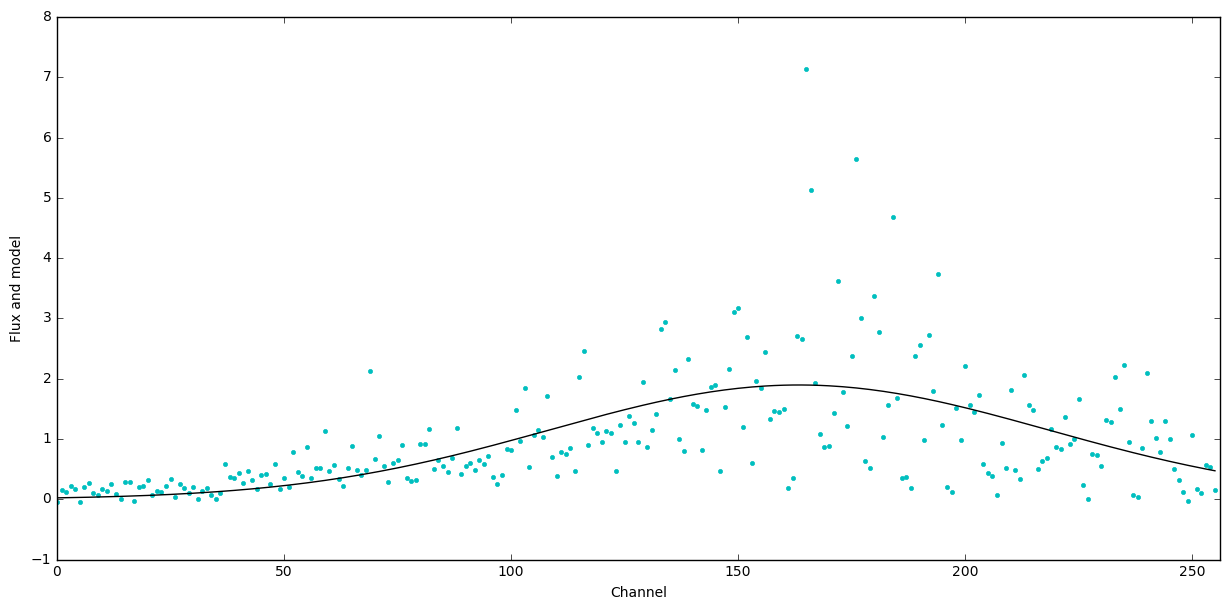

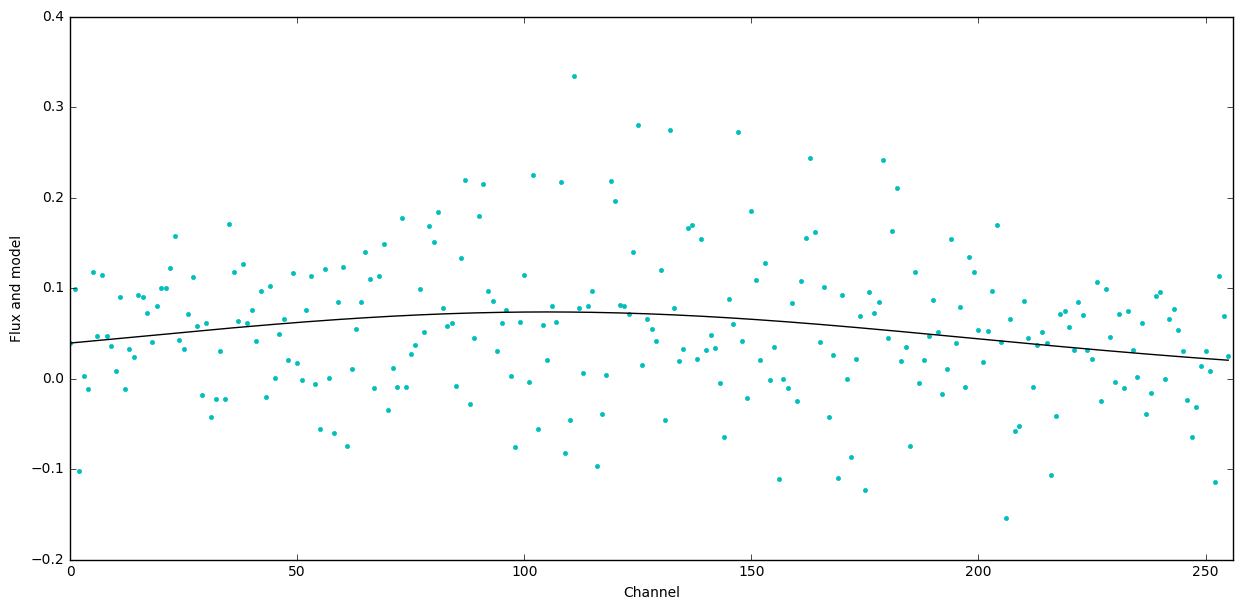

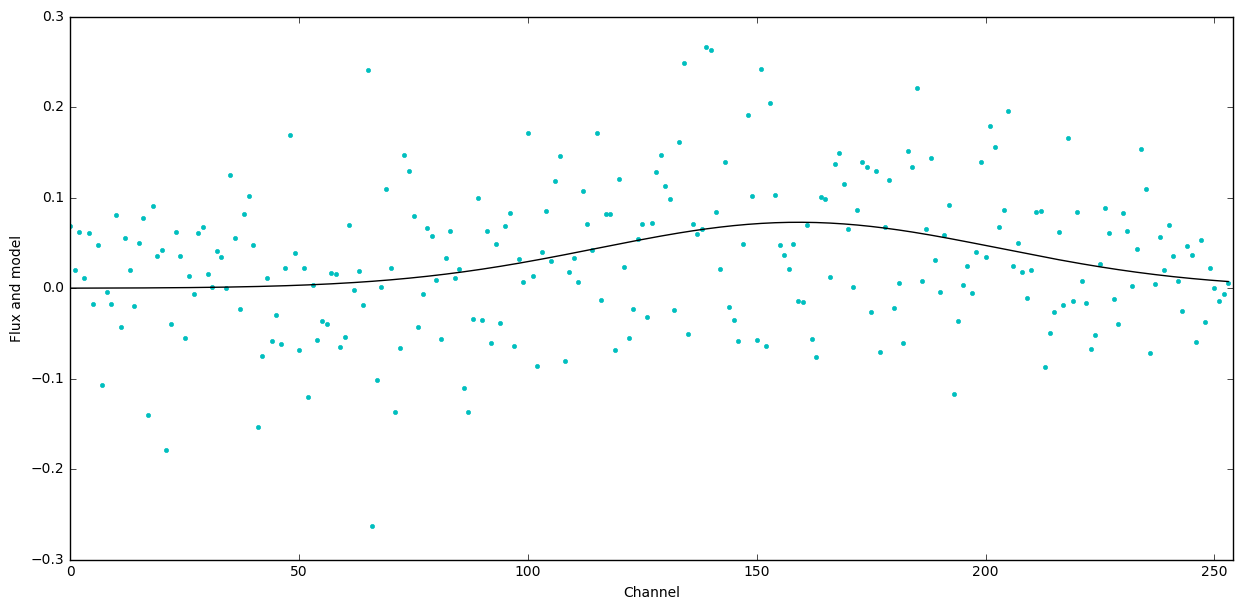

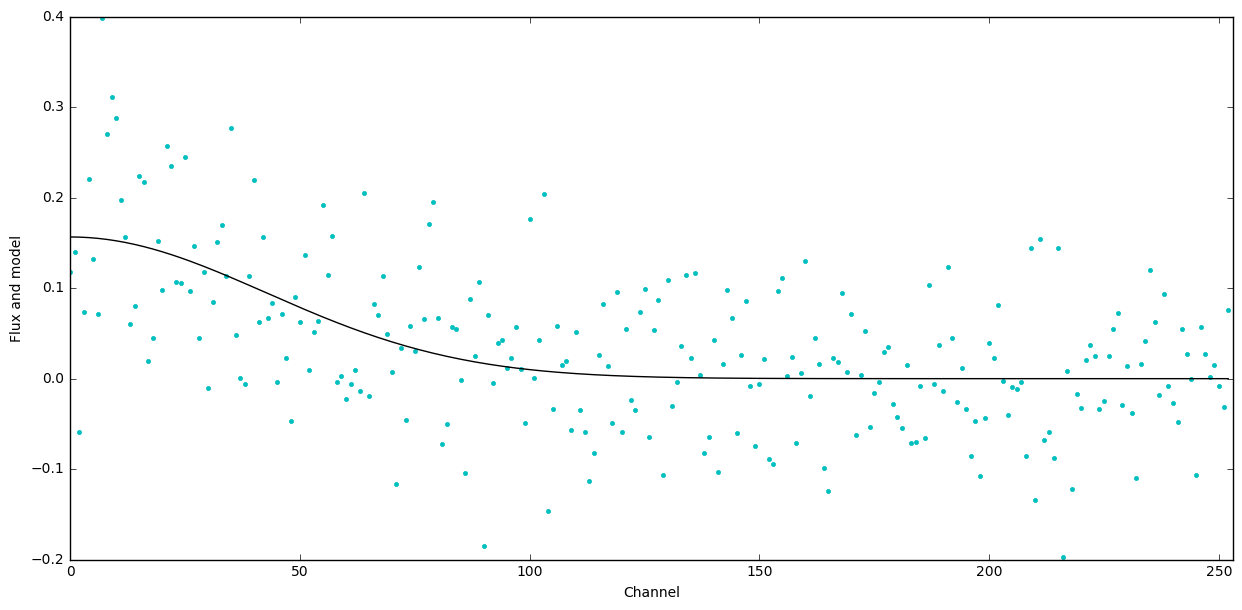

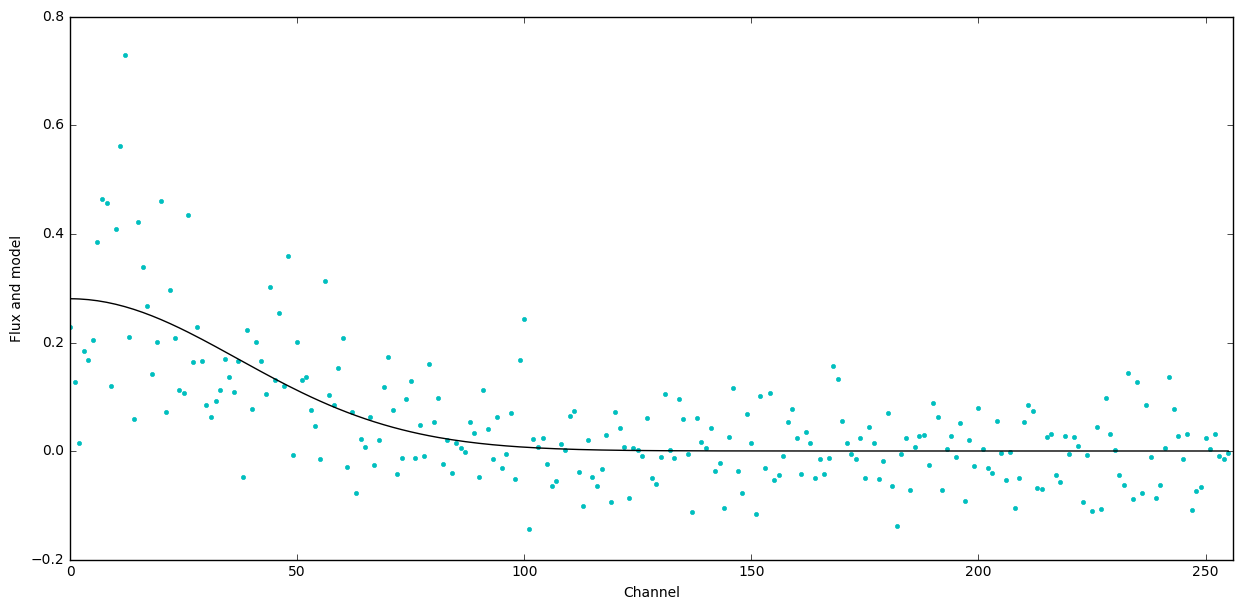

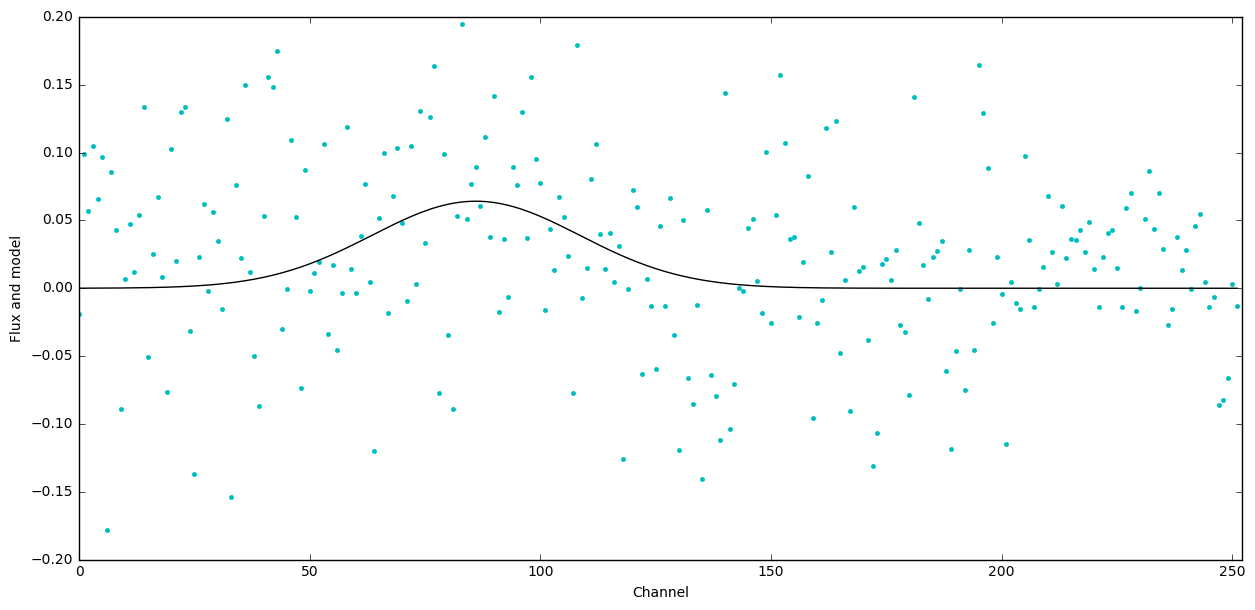

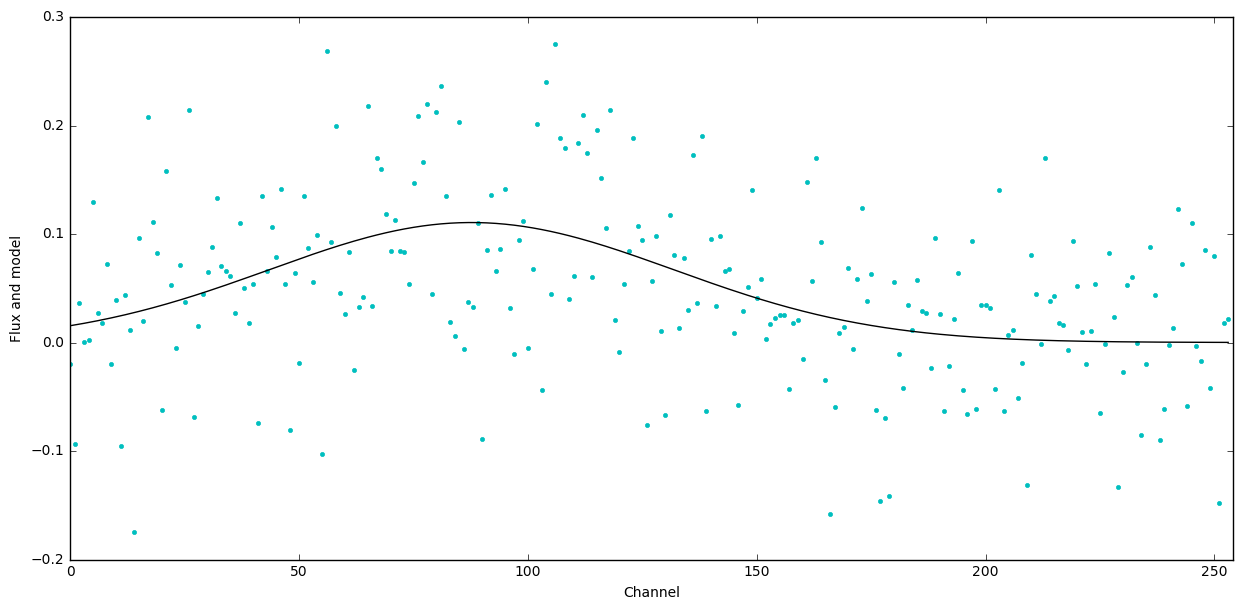

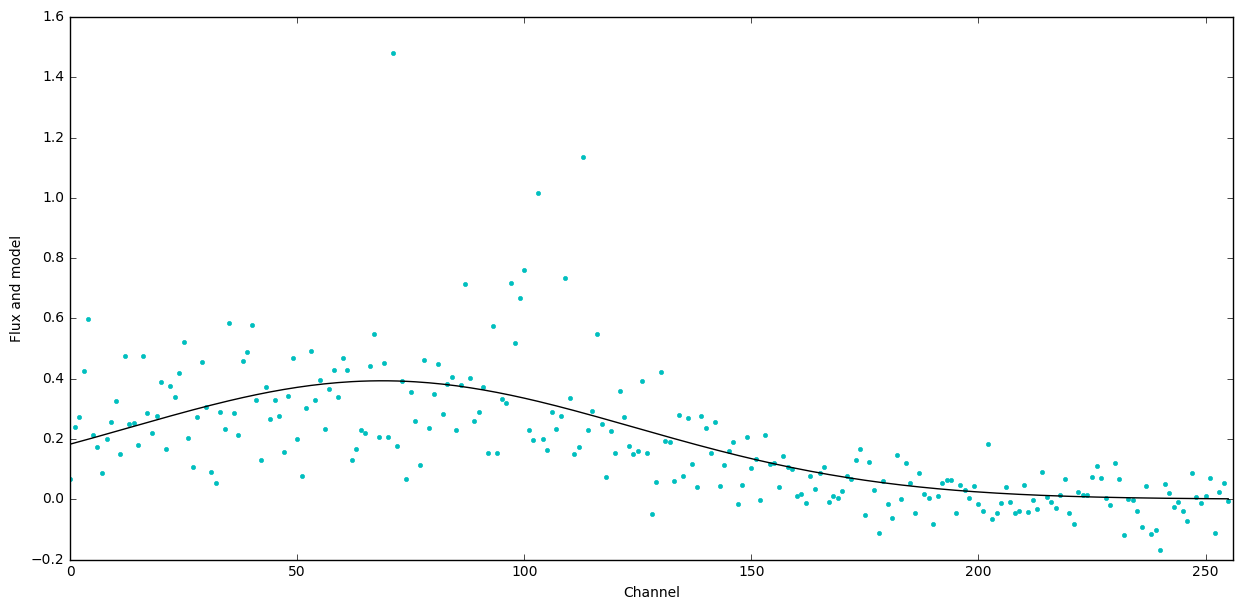

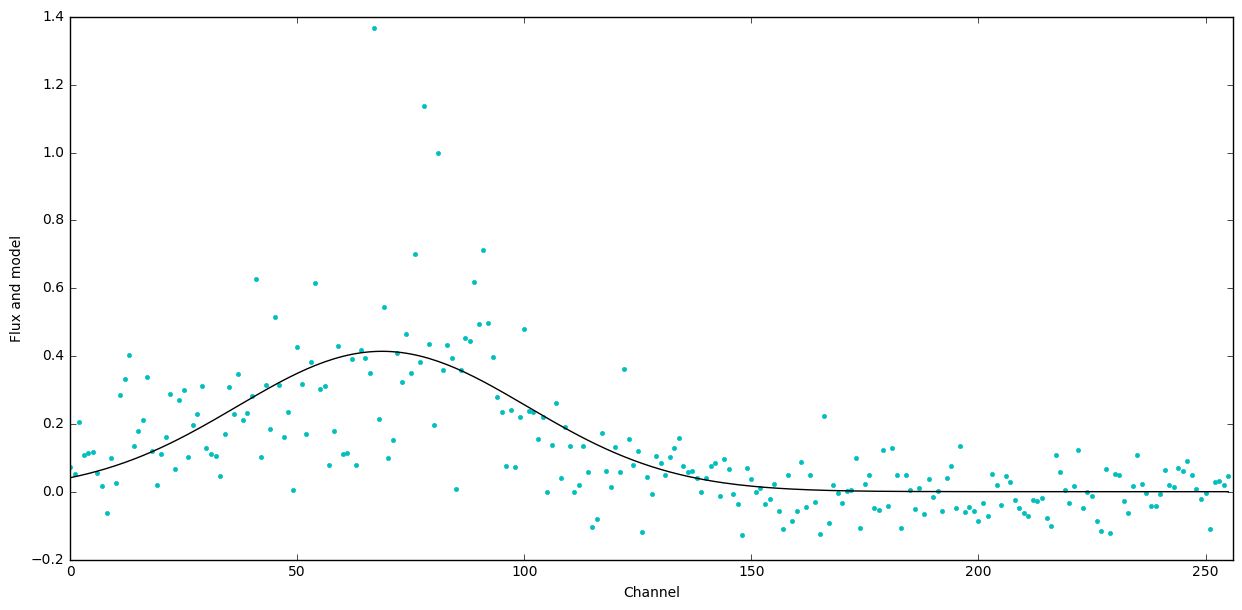

In [30]:
for key in snrdet.keys():
    spec = spectrum[key].mean(axis=1)
    if key not in popt:
        print(key)
        fitandplot(spec)
    else:
        fitandplot(spec, popt_fixed=popt[key])
        po = popt[key]
        print('Fit {0} (peak, center, fwhm): {1:.2f} & {2:.1f} & {3:.0f}'.format(key,
                                                                                  1e3*po[0]/sc(po[2]),
                                                                                  2.5+0.004*po[1],
                                                                                  2.355*4*po[2]))

## Probabilistic modeling of dispersion

In [152]:
def sample(sgram, spmod, freq, times, dms, indexes=[2], thresh=3, breakpoint=None):
    ny, nx = sgram.shape
    grid = np.zeros(shape=(len(times), len(dms), len(indexes)))
    std = np.ma.median(np.ma.abs(sgram[:,:times.min()] - np.ma.median(sgram[:,:times.min()])))/0.67
    print('Noise from MAD: {0}'.format(std))
    if breakpoint:
        ist, jst, kst = breakpoint
    else:
         ist, jst, kst = -1, -1, -1
        
    for i in range(len(times)):
        for j in range(len(dms)):
            for k in range(len(indexes)):
                model = genmodel(ny, nx, spmod, times[i], dms[j], freq, index=indexes[k])
#                diff = (sgram - model)/(2*std)  # use statistical error in measurement
                diff = (sgram - model)/np.where(model < thresh*std, 2*std, model)   # use scintillation "error" in spectrum
                exp = np.exp(-diff**2)
                grid[i,j,k] = np.ma.prod(np.ma.masked_where(sgram < thresh*std, exp))
                if k == kst:
                    break
            if j == jst:
                break
        if i == ist:
            break
    
    if breakpoint:
        print(i, j, k, times[i], dms[j], indexes[k])
        return diff, high
    else:
        return grid


def genmodel(ny, nx, spmod, i0, dm, freq, index=2, dx=0.005):
    """ Generate a 2d model of a dispersed pulse """
    
    model = np.zeros(shape=(ny, nx), dtype=float)
    delay = (4.2e-3 * dm * (1./freq**index - 1./freq[-1]**index))/dx
    normarr = norm(range(ny), *spmod)
    for y in range(0, ny):
        time = np.round(i0+delay[y], 0).astype(np.int16)
        if time < nx:
            model[y, time] = normarr[y] 
            
    return model

spec_ci = {}

In [153]:
key = '57623'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

times = np.linspace(95.5, 96.5, 50)
dms = np.linspace(540, 580, 200)
grid = sample(sgram, popt[key], st['freq'], times=times, dms=dms, thresh=3)[:,:,0]
print(grid.shape, grid.min(), grid.max())
grid = np.ma.masked_equal((grid/grid.max()).transpose(), 0) # normalize and flip to get time horizontally

2016-12-16 21:14:42,391 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Noise from MAD: 0.0731048966522
(50, 200) 0.0 4.40901150052e-152


2016-12-16 21:16:23,455 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



95.7040816327 96.1530612245 557.487437186 568.341708543


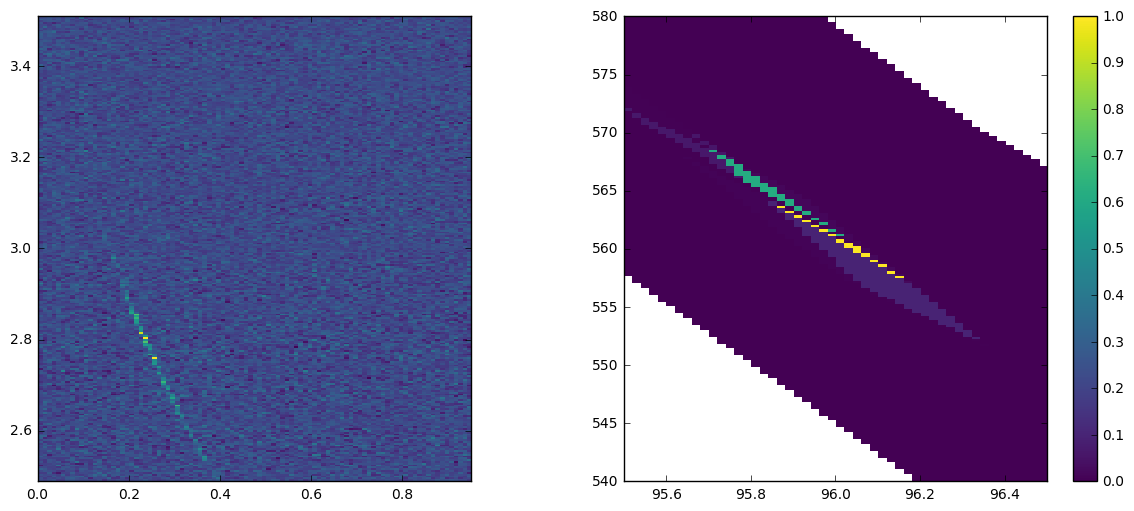

In [157]:
pl.figure(figsize=(15,6))
pl.subplot(121)
extent = (0, len(sgram[0])*st['inttime'], st['freq'][0], st['freq'][-1])
pl.imshow(sgram[:,times[0]:], interpolation='nearest', origin='lower', cmap='viridis',
          vmax=sgram.max()*0.8, extent=extent)

pl.subplot(122)
extent = (times.min(), times.max(), dms.min(), dms.max())
pl.imshow(grid, interpolation='nearest', origin='lower', cmap='viridis',
          extent=extent, aspect='auto')
pl.colorbar()

# find bounds
ci = 0.68
dmb, tb = np.where(grid > 1-ci)
print(times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])
spec_ci[key] = (times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])

In [159]:
# try again looking for non-lambda^2

times = np.linspace(90, 100, 10)
dms = np.linspace(400, 700, 150)
indexes = np.linspace(1.8, 2.2, 10)
grid = sample(sgram, popt[key], st['freq'], times=times, dms=dms, indexes=indexes, thresh=3)

2016-12-16 21:17:11,663 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Noise from MAD: 0.073215743499


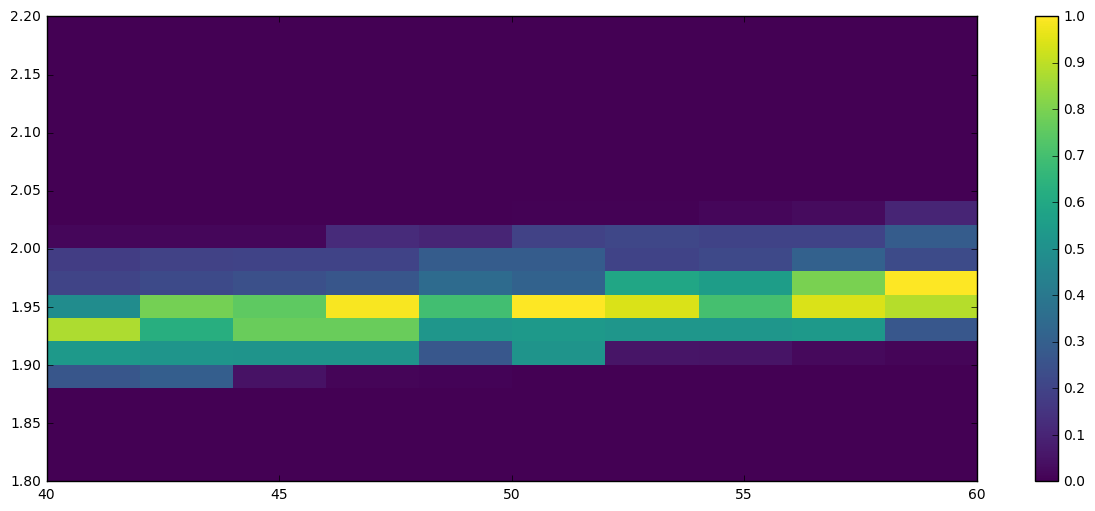

In [176]:
pl.figure(figsize=(15,6))
extent = (times.min(), times.max(), indexes.min(), indexes.max())
pl.imshow(grid.mean(axis=1)/grid.mean(axis=1).max(), interpolation='nearest', origin='lower', cmap='viridis',
          extent=extent, aspect='auto')
pl.colorbar()

In [158]:
pl.figure(figsize=(15,6))
extent = (times.min(), times.max(), indexes.min(), indexes.max())
pl.imshow(grid, interpolation='nearest', origin='lower', cmap='viridis',
          extent=extent, aspect='auto')
pl.colorbar()

# find bounds
ci = 0.68
dmb, tb = np.where(grid.mean(axis=1) > 1-ci)
print(times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])
spec_ci[key] = (times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])

2016-12-16 21:16:49,324 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Noise from MAD: 0.073215743499


KeyboardInterrupt: 

In [34]:
key = '57633_scan7'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

times=np.linspace(95.6, 96.0, 50)
dms=np.linspace(550, 570, 200)
grid = sample(sgram, popt[key], st['freq'], times=times, dms=dms, thresh=3)
print(grid.shape, grid.min(), grid.max())
grid = np.ma.masked_equal((grid/grid.max()).transpose(), 0) # normalize and flip to get time horizontally

2016-12-16 18:29:12,181 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Noise from MAD: 0.0694868057521
(50, 200) 0.0 4.14514254913e-212


2016-12-16 18:30:06,146 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



95.7959183673 95.8040816327 560.150753769 561.155778894


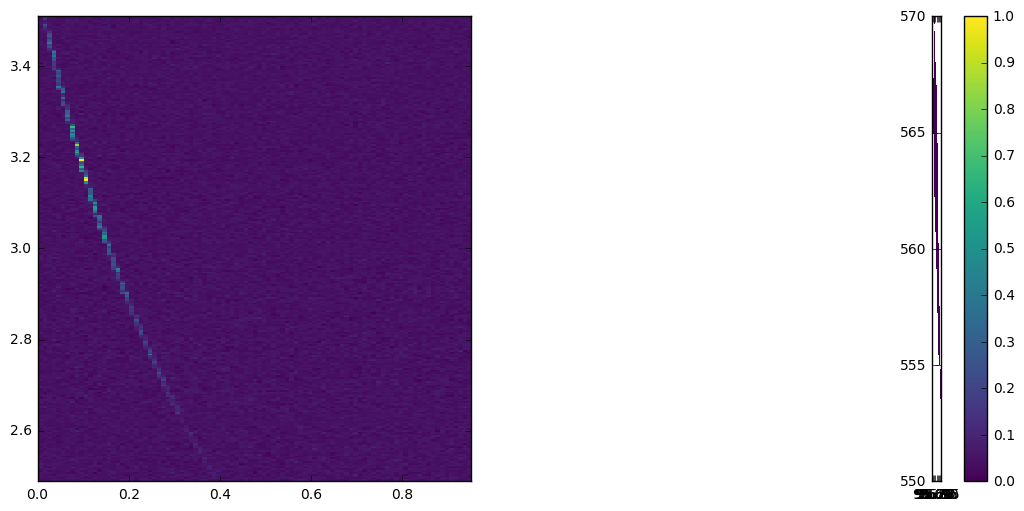

In [35]:
pl.figure(figsize=(13,6))
pl.subplot(121)
extent = (0, len(sgram[0])*st['inttime'], st['freq'][0], st['freq'][-1])
pl.imshow(sgram[:,times[0]:], interpolation='nearest', origin='lower', cmap='viridis',
          vmax=sgram.max()*0.8, extent=extent)
pl.subplot(122)
extent = (times.min(), times.max(), dms.min(), dms.max())
pl.imshow(grid, interpolation='nearest', origin='lower', cmap='viridis', extent=extent)
pl.colorbar()

# find bounds
ci = 0.68
dmb, tb = np.where(grid > 1-ci)
print(times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])
spec_ci[key] = (times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])

In [36]:
key = '57633_scan13'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

times=np.linspace(93, 99, 50)
dms=np.linspace(520, 590, 200)
grid = sample(sgram, popt[key], st['freq'], times=times, dms=dms, thresh=3)
print(grid.shape, grid.min(), grid.max())
grid = np.ma.masked_equal((grid/grid.max()).transpose(), 0) # normalize and flip to get time horizontally

2016-12-16 18:30:07,722 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Noise from MAD: 0.0692616536546
(50, 200) 4.11898415575e-116 1.63648906168e-89


2016-12-16 18:31:01,023 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



94.8367346939 97.4081632653 535.829145729 580.854271357


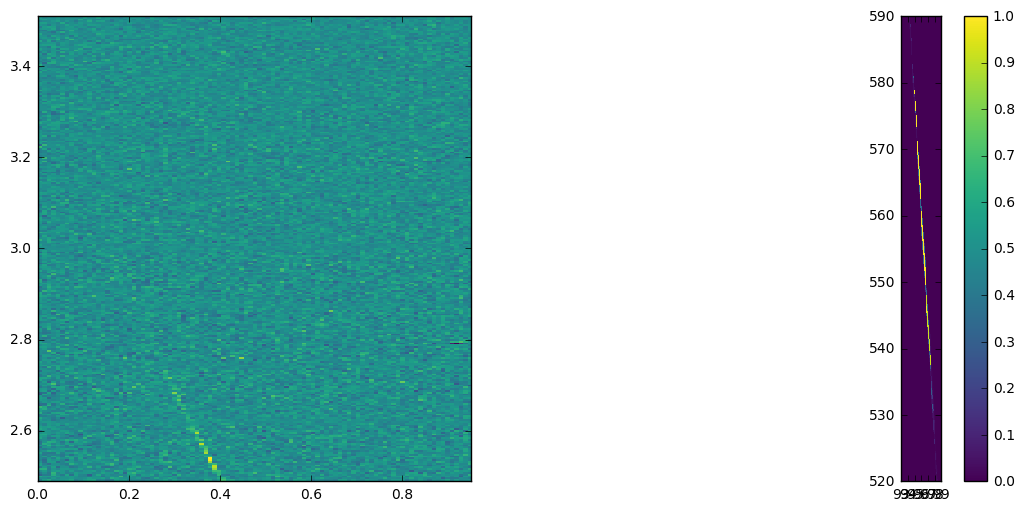

In [37]:
pl.figure(figsize=(13,6))
pl.subplot(121)
extent = (0, len(sgram[0])*st['inttime'], st['freq'][0], st['freq'][-1])
pl.imshow(sgram[:,times[0]:], interpolation='nearest', origin='lower', cmap='viridis',
          vmax=sgram.max()*0.8, extent=extent)
pl.subplot(122)
extent = (times.min(), times.max(), dms.min(), dms.max())
pl.imshow(grid, interpolation='nearest', origin='lower', cmap='viridis', extent=extent)
pl.colorbar()

# find bounds
ci = 0.68
dmb, tb = np.where(grid > 1-ci)
print(times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])
spec_ci[key] = (times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])

In [38]:
key = '57638'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

times=np.linspace(58, 63, 20)
dms=np.linspace(480, 650, 200)
grid = sample(sgram, popt[key], st['freq'], times=times, dms=dms, thresh=3)
print(grid.shape, grid.min(), grid.max())
grid = np.ma.masked_equal((grid/grid.max()).transpose(), 0) # normalize and flip to get time horizontally

2016-12-16 18:31:02,244 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Noise from MAD: 0.0709305503475
(20, 200) 1.19623185053e-49 4.27518876888e-48


2016-12-16 18:31:20,133 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



59.3157894737 62.7368421053 480.0 647.43718593


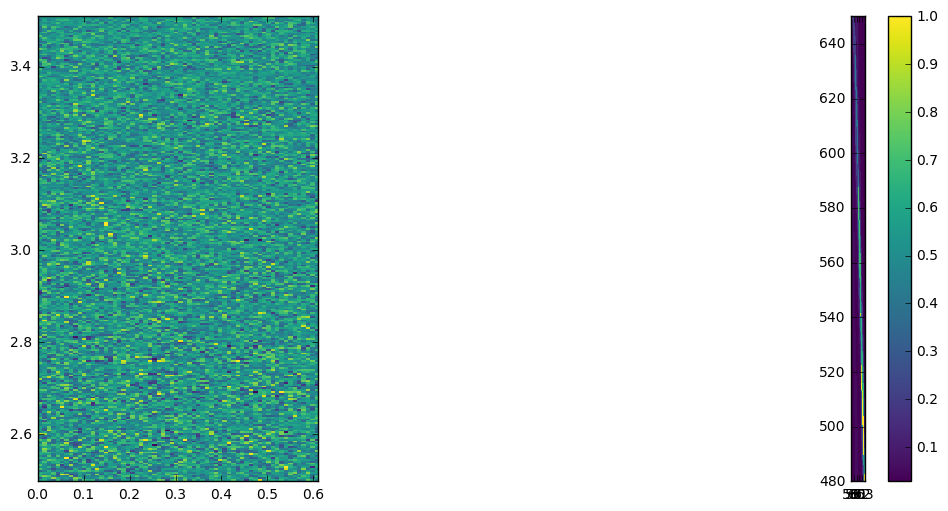

In [39]:
pl.figure(figsize=(13,6))
pl.subplot(121)
extent = (0, len(sgram[0])*st['inttime'], st['freq'][0], st['freq'][-1])
pl.imshow(sgram[:,times[0]:], interpolation='nearest', origin='lower', cmap='viridis',
          vmax=sgram.max()*0.8, extent=extent)
pl.subplot(122)
extent = (times.min(), times.max(), dms.min(), dms.max())
pl.imshow(grid, interpolation='nearest', origin='lower', cmap='viridis', extent=extent)
pl.colorbar()

# find bounds
ci = 0.68
dmb, tb = np.where(grid > 1-ci)
print(times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])
spec_ci[key] = (times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])

In [129]:
key = '57643'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

times=np.linspace(61.5, 62.5, 50)
dms=np.linspace(555, 560, 200)
grid = sample(sgram, popt[key], st['freq'], times=times, dms=dms, thresh=3)
print(grid.shape, grid.min(), grid.max())
grid = np.ma.masked_equal((grid/grid.max()).transpose(), 0) # normalize and flip to get time horizontally

2016-12-16 20:45:16,224 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Noise from MAD: 0.0662440739906
(50, 200) 5.03093029961e-233 7.49240548098e-93


In [ ]:
pl.figure(figsize=(13,6))
pl.subplot(121)
extent = (0, len(sgram[0])*st['inttime'], st['freq'][0], st['freq'][-1])
pl.imshow(sgram[:,times.min():], interpolation='nearest', origin='lower', cmap='viridis',
          vmax=sgram.max()*0.8, extent=extent)
pl.subplot(122)
extent = (times.min(), times.max(), dms.min(), dms.max())
pl.imshow(grid, interpolation='nearest', origin='lower', cmap='viridis', extent=extent)
pl.colorbar()

# find bounds
ci = 0.68
dmb, tb = np.where(grid > 1-ci)
print(times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])
spec_ci[key] = (times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])

In [120]:
key = '57645'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

times=np.linspace(10, 50, 80)
dms=np.linspace(500, 700, 100)
grid = sample(sgram, popt[key], st['freq'], times=times, dms=dms, thresh=3)
print(grid.shape, grid.min(), grid.max())
grid = np.ma.masked_equal((grid/grid.max()).transpose(), 0) # normalize and flip to get time horizontally

2016-12-16 19:48:28,319 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Noise from MAD: 0.071387554505
(80, 100) 6.90025245976e-29 1.32429495401e-28


2016-12-16 19:49:01,915 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



10.0 50.0 500.0 700.0


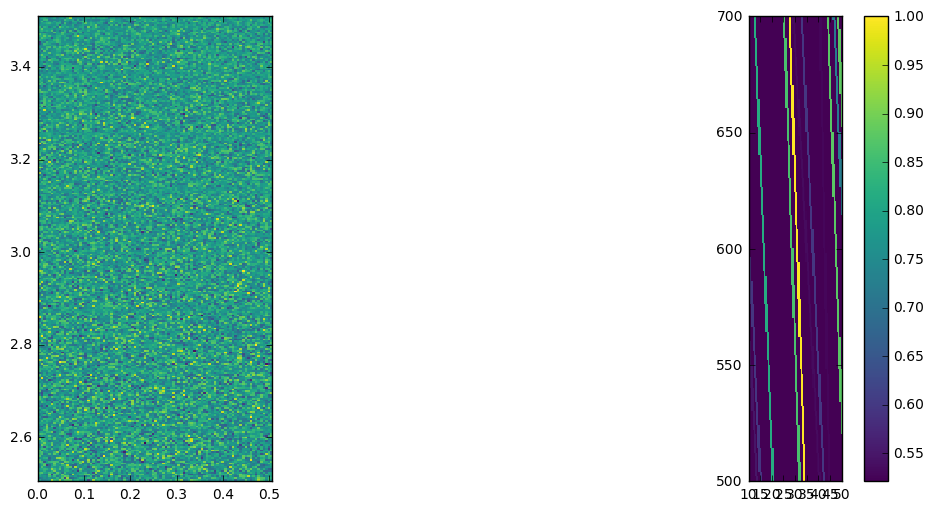

In [121]:
pl.figure(figsize=(13,6))
pl.subplot(121)
extent = (0, len(sgram[0])*st['inttime'], st['freq'][0], st['freq'][-1])
pl.imshow(sgram[:,times[0]:], interpolation='nearest', origin='lower', cmap='viridis',
          vmax=sgram.max()*0.8, extent=extent)
pl.subplot(122)
extent = (times.min(), times.max(), dms.min(), dms.max())
pl.imshow(grid, interpolation='nearest', origin='lower', cmap='viridis', extent=extent)
pl.colorbar()

# find bounds
ci = 0.68
dmb, tb = np.where(grid > 1-ci)
print(times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])
spec_ci[key] = (times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])

In [44]:
key = '57646'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

times=np.linspace(46, 54, 20)
dms=np.linspace(500, 600, 200)
grid = sample(sgram, popt[key], st['freq'], times=times, dms=dms, thresh=3, index=2)
print(grid.shape, grid.min(), grid.max())
grid = np.ma.masked_equal((grid/grid.max()).transpose(), 0) # normalize and flip to get time horizontally

2016-12-16 18:32:42,308 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Noise from MAD: 0.0650329932348
(20, 200) 2.14164704424e-51 3.95361155276e-43


2016-12-16 18:32:58,981 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



46.0 50.6315789474 512.060301508 589.447236181


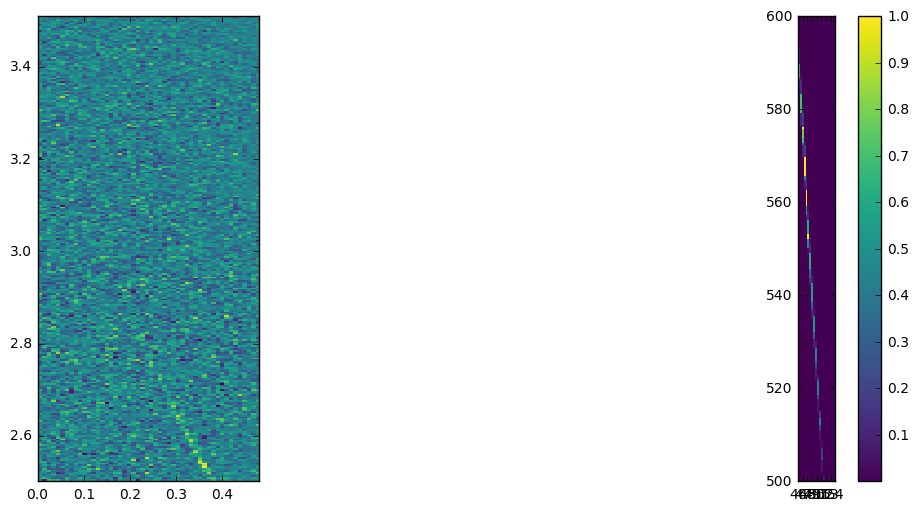

In [45]:
pl.figure(figsize=(13,6))
pl.subplot(121)
extent = (0, len(sgram[0])*st['inttime'], st['freq'][0], st['freq'][-1])
pl.imshow(sgram[:,times[0]:], interpolation='nearest', origin='lower', cmap='viridis',
          vmax=sgram.max()*0.8, extent=extent)
pl.subplot(122)
extent = (times.min(), times.max(), dms.min(), dms.max())
pl.imshow(grid, interpolation='nearest', origin='lower', cmap='viridis', extent=extent)
pl.colorbar()

# find bounds
ci = 0.68
dmb, tb = np.where(grid > 1-ci)
print(times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])
spec_ci[key] = (times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])

In [174]:
# try again looking for non-lambda^2
key = '57646'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

times=np.linspace(40, 60, 20)
dms=np.linspace(400, 700, 200)
indexes = np.linspace(1.8, 2.2, 10)
grid = sample(sgram, popt[key], st['freq'], times=times, dms=dms, indexes=indexes, thresh=3)

2016-12-16 21:23:39,038 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Noise from MAD: 0.065977704614


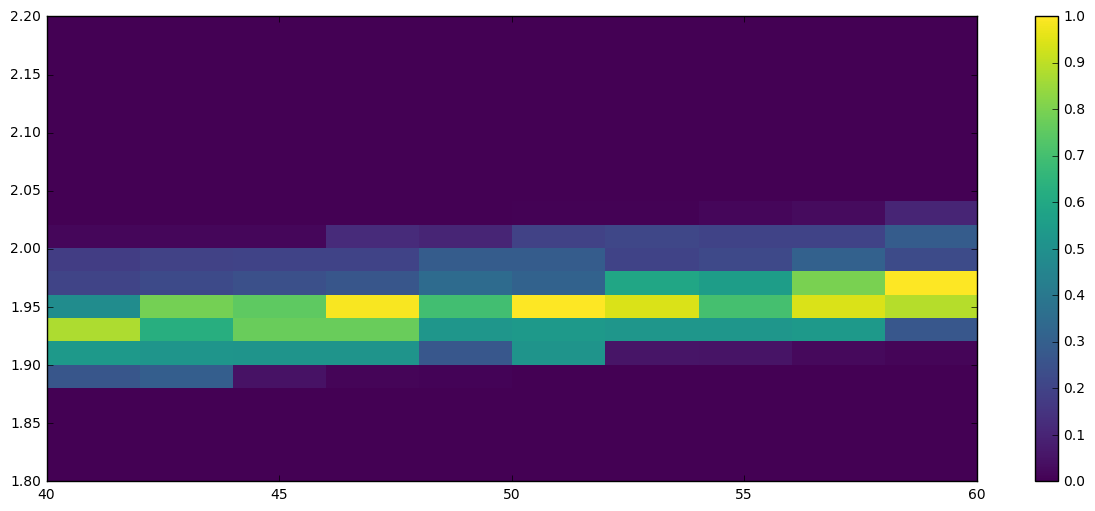

In [177]:
pl.figure(figsize=(15,6))
extent = (times.min(), times.max(), indexes.min(), indexes.max())
pl.imshow(grid.mean(axis=1)/grid.mean(axis=1).max(), interpolation='nearest', origin='lower', cmap='viridis',
          extent=extent, aspect='auto')
pl.colorbar()

In [46]:
key = '57648'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

times=np.linspace(40, 50, 20)
dms=np.linspace(500, 600, 200)
grid = sample(sgram, popt[key], st['freq'], times=times, dms=dms, thresh=3)
print(grid.shape, grid.min(), grid.max())
grid = np.ma.masked_equal((grid/grid.max()).transpose(), 0) # normalize and flip to get time horizontally

2016-12-16 18:32:59,955 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Noise from MAD: 0.069573477133
(20, 200) 1.36751943653e-30 8.15145029003e-27


2016-12-16 18:33:16,412 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



42.6315789474 45.2631578947 522.613065327 593.969849246


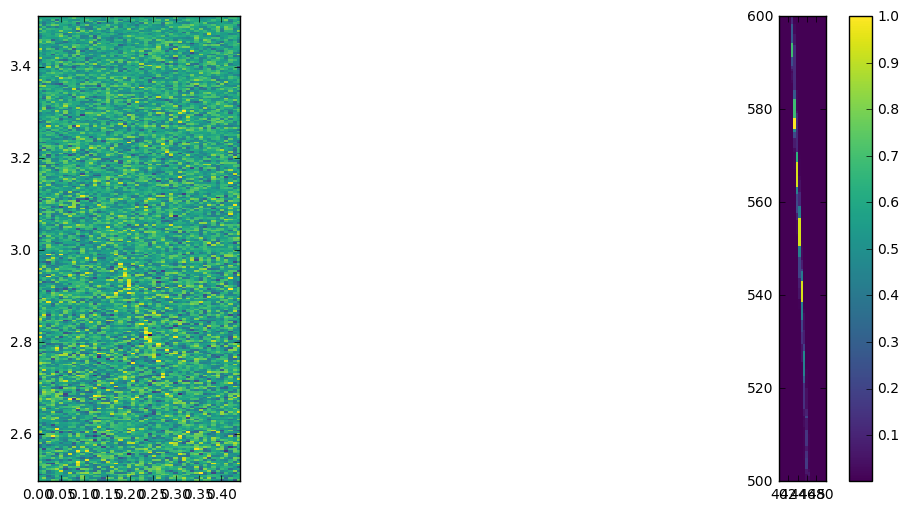

In [47]:
pl.figure(figsize=(13,6))
pl.subplot(121)
extent = (0, len(sgram[0])*st['inttime'], st['freq'][0], st['freq'][-1])
pl.imshow(sgram[:, times[0]:], interpolation='nearest', origin='lower', cmap='viridis',
          vmax=sgram.max()*0.8, extent=extent)
pl.subplot(122)
extent = (times.min(), times.max(), dms.min(), dms.max())
pl.imshow(grid, interpolation='nearest', origin='lower', cmap='viridis', extent=extent)
pl.colorbar()

# find bounds
ci = 0.68
dmb, tb = np.where(grid > 1-ci)
print(times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])
spec_ci[key] = (times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])

In [48]:
key = '57649'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

times=np.linspace(40, 47, 20)
dms=np.linspace(530, 630, 200)
grid = sample(sgram, popt[key], st['freq'], times=times, dms=dms, thresh=3)
print(grid.shape, grid.min(), grid.max())
grid = np.ma.masked_equal((grid/grid.max()).transpose(), 0) # normalize and flip to get time horizontally

2016-12-16 18:33:17,363 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Noise from MAD: 0.0692452846178
(20, 200) 3.36222388473e-52 1.8324179494e-48


2016-12-16 18:33:33,909 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



43.3157894737 45.1578947368 544.572864322 613.417085427


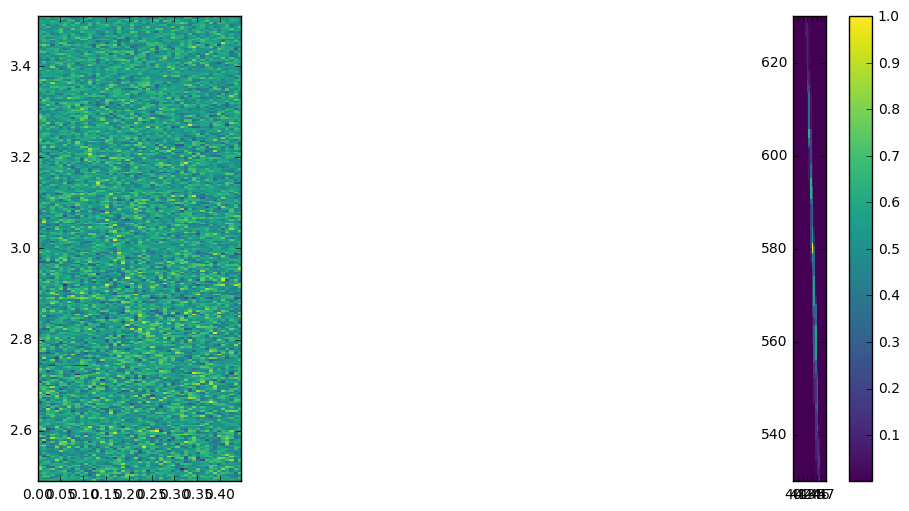

In [49]:
pl.figure(figsize=(13,6))
pl.subplot(121)
extent = (0, len(sgram[0])*st['inttime'], st['freq'][0], st['freq'][-1])
pl.imshow(sgram[:, times[0]:], interpolation='nearest', origin='lower', cmap='viridis',
          vmax=sgram.max()*0.8, extent=extent)
pl.subplot(122)
extent = (times.min(), times.max(), dms.min(), dms.max())
pl.imshow(grid, interpolation='nearest', origin='lower', cmap='viridis', extent=extent)
pl.colorbar()

# find bounds
ci = 0.68
dmb, tb = np.where(grid > 1-ci)
print(times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])
spec_ci[key] = (times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])

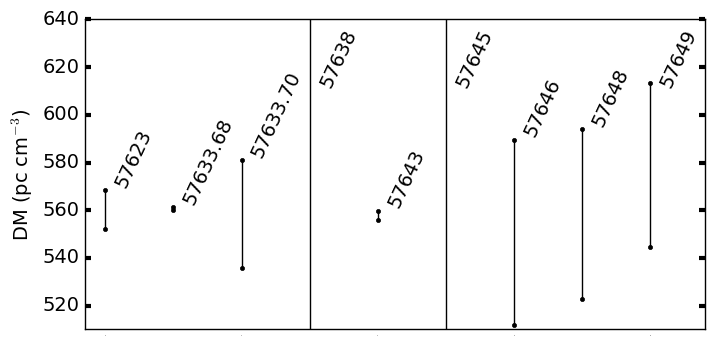

In [128]:
pl.figure(figsize=(8,4))
ax = pl.subplot(111)
i=0
keys = ['57623', '57633_scan7', '57633_scan13', '57638', '57643', '57645', '57646', '57648', '57649']
label = ['57623', '57633.68', '57633.70', '57638', '57643', '57645', '57646', '57648', '57649']
for key in keys:
    t0, t1, d0, d1 = spec_ci[key]
    pl.plot([i, i], [d0, d1], '.-k')
    pl.text(i+0.1, min(d1, 610), str(label[i]), rotation=65, fontsize=14, verticalalignment='bottom')
    i += 1
pl.xlim(-0.3,8.8)
pl.ylim(510,640)
pl.ylabel('DM (pc cm$^{-3}$)', fontsize=14)
xt = pl.setp(ax.get_xticklabels(), fontsize=0)
yt = pl.setp(ax.get_yticklabels(), fontsize=14)
ax.xaxis.set_tick_params(width=0, color='k')
ax.yaxis.set_tick_params(width=3, color='k')